## Heart Attack Prediction Model 
## Preproceessing - Feature Engineering, Data Preparation
## Modeling - Baseline Modeling, Baseline Model Evaluations 

---


## Author: Will Wu

## Date: 2025-03-14
---

## **Table of Contents** ##
1. [Defining Metrics of Success](#1)
2. [Setup and Load Data](#2)
3. [Initial Feature Engineering](#3)
    - [Binning Data - `bmi`](#3a)
    - [Feature Selection](#3b)
4.  [Data Preparation](#4)
    - [Binary Encoding](#4a)
    - [Train-Test-Split](#4b)
    - [Log Transformation of Non-Normal Features](#4c)
    - [One-Hot Encoding](#4d)
    - [Feature Scaling](#4e)
    - [Handling Class Imbalance](#4f)
    - [Reducing Dimensionality using PCA](#4g)
    - [Additional preparations](#4h)
     
5. [Baseline Modeling - Logistic Regression](#5)
    - [Logistic Regression With Imbalanced Class](#5a)
    - [Logistic Regression With Upsampling](#5b)
    - [Logistic Regression With Downsampling](#5c)
    - [Logistic Regression With Oversampling](#5d)
    - [Best Model with PCA](#5e)
    - [Logistic Regression Baseline Modeling Summary](#5f)

6. [Baseline Modeling - Naive Bayes](#6)
    - [Naive Bayes With Imbalanced Class](#6a)
    - [Naive Bayes With Upsampling](#6b)
    - [Naive Bayes With Downsampling](#6c)
    - [Naive Bayes Baseline Modeling Summary](#6d)

7. [Baseline Modeling - Decision Tree](#7)
    - [Decision Tree With Imbalanced Class](#7a)
    - [Decision Tree With Upsampling](#7b)
    - [Decision Tree With Downsampling](#7c)
    - [Best Model with PCA](#7d)
    - [Decision Tree Baseline Modeling Summary](#7e)

8. [Baseline Modeling - Random Forest](#8)
    - [Random Forest With Imbalanced Class](#8a)
    - [Random Forest With Upsampling](#8b)
    - [Random Forest With Downsampling](#8c)
    - [Random Forest Baseline Modeling Summary](#8d)

9. [Baseline Modeling - XGBoost](#9)
    - [XGBoost With Imbalanced Class](#9a)
    - [XGBoost With Upsampling](#9b)
    - [XGBoost With Downsampling](#9c)
    - [Best Model with PCA](#9d)
    - [XGBoost Baseline Modeling Summary](#9e)

10. [Comparison of Baseline Models and Summary](#10)
    - [Important/Predictive Features in Various Baseline Models](#10a)
    - [Model Comparison and Summary](#10b)

11. [Export Data](#11)



---

## 1. Defining Metrics of Success<a class="anchor" id="1"></a>

- The primary purpose of this notebook is to establish baseline models, which will involve feature engineering, data preparation, training various models, and model evaluations. Before diving into these steps, I will first define the metrics of success to help set the tone and direction of the modeling process.
- Given the highly imbalanced distribution of the target variable (94.7% negative vs. 5.3% positive), **accuracy is not a suitable metric**. A simple classifier that predicts all targets as negative would achieve an impressive accuracy of 94.7%, yet it would fail to identify any positive cases. Therefore, alternative metrics that better capture the model's performance on the minority class should be considered.
- Considering that the goal of this project is to create an early detection system for identifying the risk of a heart attack, the **primary objective** of the modeling is to achieve a **high recall score**. Recall measures the model's ability to correctly identify true positive cases, which is crucial for timely intervention.
- A **low false positive rate** is also important, and should be considered as the **secondary goal**. An excessively high recall can lead to many false positives, where low-risk individuals are incorrectly flagged as high-risk. This results in unnecessary medical consultations and interventions, causing undue stress and resource waste for those not at risk, ultimately compromising the model's reliability and fostering skepticism about its usefulness.
- Therefore, **the model should prioritize a high recall to ensure safety through early detection while balancing with a manageable false positive rate to maintain efficiency and trust in its predictions.**

---

## 2. Setup and Loading<a class="anchor" id="2"></a>

In [83]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_classif, f_regression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier 
from xgboost import XGBClassifier

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.utils import resample



In [84]:
# Setting figure size, fontsize globally in the notebook
plt.rcParams["figure.figsize"] = (6.0, 6.0)

# Set default grid
sns.set_style('darkgrid')

In [85]:
# Load the dataset
df = pd.read_csv("../data/processed/heart_attack_clean_final.csv")

In [86]:
# Check top 5 rows
df.head()

,year,sex,race_ethnicity_category,age_category,state,height,weight,bmi,alcohol_drinkers,general_health,...,difficulty_walking,difficulty_concentrating,difficulty_dressing_bathing,difficulty_errands,last_checkup_time,chest_scan,flu_vax,tetanus_vax,pneumo_vax,had_heart_attack
0,2022,Female,White,80+,Alabama,1.60,78.02,30.48,No,Very good,...,Yes,No,No,No,Past 1-2 years,not_asked,No,not_asked,No,No
1,2022,Female,White,80+,Alabama,1.45,59.87,28.48,No,Very good,...,No,No,No,No,Past 1-2 years,not_asked,Yes,not_asked,Yes,No
2,2022,Female,Black,80+,Alabama,1.63,58.97,22.20,No,Fair,...,Yes,Yes,No,No,Past year,not_asked,Yes,not_asked,Yes,No
3,2022,Female,White,75-79,Alabama,1.68,77.11,27.32,No,Very good,...,Yes,No,No,No,Past 2-5 years,not_asked,Yes,not_asked,Yes,No
4,2022,Female,White,75-79,Alabama,1.73,77.11,25.76,Yes,Fair,...,Yes,Yes,No,Yes,Past year,not_asked,No,not_asked,Yes,No


---

## 3. Initial Feature Engineering <a class="anchor" id="3"></a>

In [87]:
# Create a feature engineer df
df_engineer = df.copy()

### 3.1 Binning Data - `bmi`  <a class="anchor" id="3a"></a>

- From preliminary EDA, the distribution of `bmi` is slightly right-skewed, with notable outliers at the higher end. Therefore, converting bmi into bins could be beneficial in mitigating the impact of these outliers.
- According to the BMI definition, individuals are categorized as 'underweight' (bmi < 18.5), 'healthy' (18.5 <= bmi < 25), 'overweight' (25 <= bmi < 30), or 'obese' (bmi > 30). Preliminary EDA findings indicate that the boundary between 'healthy' and 'obese' (BMI of 25) is a critical point, with those below this threshold less likely to experience a heart attack. Thus, I aim to bin the numeric BMI values into categories to explore how the likelihood of having a heart attack varies. To approach this, I will:
    - Create a subset that stores `bmi`, target varaible `had_heart_attack`, and create a bmi_category column
    - Calculate the possibility of having a heart attack for each bmi_category
    - Visulize the possibility to see if there is any difference.

In [88]:
# Create a function that turns bmi into bins
def get_bmi_bin(bmi):
    """
    Return the BMI category based on the input bmi value.

    If bmi <= 0, raise ValueError.

    Args:
        bmi (float): Numeric BMI value.

    Returns:
        str: One of the following categories: 'underweight', 'healthy', 'overweight', 'obese'.

    """
    if bmi <= 0:
        raise ValueError('BMI cannot be less or equal to Zero.')

    match bmi:
        case _ if bmi < 18.5:
            return 'underweight'
        case _ if bmi < 25:
            return 'healthy'
        case _ if bmi < 30:
            return 'overweight'
        case _:
            return 'obese'


In [89]:
# Create a new subset with bmi and had_heart_attack
bmi_df = df_engineer[['bmi', 'had_heart_attack']].copy()

# Create a new column that maps bmi into category
bmi_df['bmi_category'] = bmi_df['bmi'].apply(get_bmi_bin)
bmi_df.head()

,bmi,had_heart_attack,bmi_category
0,30.48,No,obese
1,28.48,No,overweight
2,22.20,No,healthy
3,27.32,No,overweight
4,25.76,No,overweight


In [90]:
# Find the percentage of people who had heart_attack within each bmi_category
bmi_likelihood_df = (bmi_df.groupby('bmi_category')['had_heart_attack']\
                     .value_counts(normalize=True)*100).unstack()

bmi_likelihood_df

had_heart_attack,No,Yes
bmi_category,,
healthy,95.750308,4.249692
obese,93.860508,6.139492
overweight,94.667780,5.332220
underweight,94.787380,5.212620


In [91]:
# Calculate the Overall probability of having a heart attack
p_heart_attack = (bmi_df['had_heart_attack'].value_counts(normalize=True) * 100)
p_heart_attack = p_heart_attack['Yes']
print(f"The overall probability of having a heart attack {p_heart_attack:.2f}%")

The overall probability of having a heart attack 5.28%


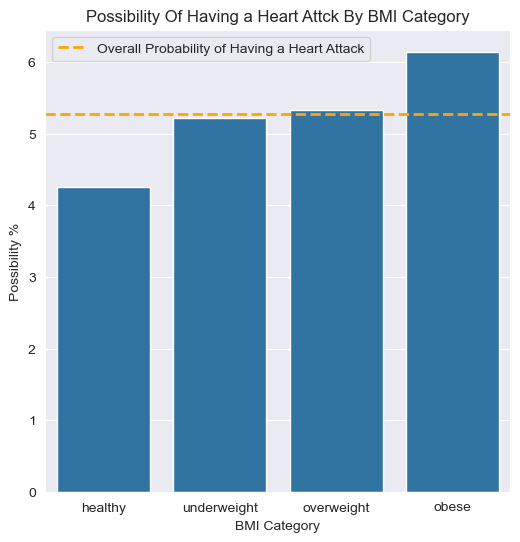

In [92]:
# Plot the likelihood of having a heart attack by bmi_category
plt.figure(figsize=(6, 6))

# Plot the likelihood of having a heart attack by each bmi_category
sns.barplot(x='bmi_category', y='Yes', data=bmi_likelihood_df.sort_values(by='Yes') )

# Plot the horizontal line of Overall probability of having a heart attack
plt.axhline(y=p_heart_attack, 
            ls='--', 
            lw=2, 
            color='orange', 
            label='Overall Probability of Having a Heart Attack'
            )
plt.title('Possibility Of Having a Heart Attck By BMI Category')
plt.xlabel('BMI Category')
plt.ylabel('Possibility %')
plt.xticks(rotation=0)
plt.legend()

plt.show()

**Takeaways**:
- The likelihood of having a heart attack differs across various BMI categories. The 'healthy' group shows a notably lower likelihood of experiencing a heart attack, while the 'obese' group exhibits a higher likelihood.
- Consequently, I will add a new feature, `bmi_category` to to categorize the `bmi` values.

In [93]:
# Create bmi_category column
bmi_category = df_engineer['bmi'].apply(get_bmi_bin)

# Insert the column into 8th position
df_engineer.insert(loc=8, column='bmi_category', value=bmi_category)

In [94]:
# Sanity Check
df_engineer['age_category'].isna().sum()

0

In [95]:
# Check the head of df
df_engineer.head().T

,0,1,2,3,4
year,2022,2022,2022,2022,2022
sex,Female,Female,Female,Female,Female
race_ethnicity_category,White,White,Black,White,White
age_category,80+,80+,80+,75-79,75-79
state,Alabama,Alabama,Alabama,Alabama,Alabama
height,1.6,1.45,1.63,1.68,1.73
weight,78.02,59.87,58.97,77.11,77.11
bmi,30.48,28.48,22.2,27.32,25.76
bmi_category,obese,overweight,healthy,overweight,overweight
alcohol_drinkers,No,No,No,No,Yes


---

### 3.2 Feature Selection <a class="anchor" id="3b"></a>


I will proceed to run various models using the full dataset without conducting feature selection at this stage. After evaluating the performance metrics, I will determine if feature selection or additional feature engineering are necessary.

---

## 4. Data Preparation  <a class="anchor" id="4"></a>

### 4.1 Binary Encoding <a class="anchor" id="4a"></a>

Transform binary columns into 1 and 0.

In [96]:
# Create a copy of df
df_encoded = df_engineer.copy()

Fetch binary columns, and print unique values within each binary column.

In [97]:
# Create an empty list
binary_cols = []

# Iterate each column, find the one that are both binary and categorical
for col in df_encoded.columns:
    if (df_encoded[col].nunique() == 2) & (df_encoded[col].dtype == 'object'):
        print(f'Column Name: {col}')
        print(f'Unique Values: {df[col].unique()}')
        print('----' * 8)

        # Append to the list
        binary_cols.append(col)



Column Name: sex
Unique Values: ['Female' 'Male']
--------------------------------
Column Name: physical_activities
Unique Values: ['No' 'Yes']
--------------------------------
Column Name: had_angina
Unique Values: ['No' 'Yes']
--------------------------------
Column Name: had_stroke
Unique Values: ['No' 'Yes']
--------------------------------
Column Name: had_asthma
Unique Values: ['No' 'Yes']
--------------------------------
Column Name: had_heart_attack
Unique Values: ['No' 'Yes']
--------------------------------


Most of the columns are 'Yes' and 'No' column, I will create dictionaries for mapping these columns into 1 and 0. Before encoding, I will first check the top for rows in df_encoded DataFrame.

In [98]:
# Check the head of df_encoded
df_encoded[binary_cols].head()

,sex,physical_activities,had_angina,had_stroke,had_asthma,had_heart_attack
0,Female,No,No,No,No,No
1,Female,Yes,No,No,No,No
2,Female,Yes,No,No,Yes,No
3,Female,Yes,No,No,No,No
4,Female,Yes,No,No,No,No


In [99]:
# Create dictionaries for mapping
yes_no = {
    'Yes' : 1,
    'No' : 0
}

is_female = {
    'Female' : 1,
    'Male' : 0
}

In [100]:
# Turn binary columns into binary values
for col in binary_cols:

    if col == 'sex': 
        df_encoded[col] = df_encoded[col].map(is_female)  # If the column is sex, use is_female for map
    else:
        df_encoded[col] = df_encoded[col].map(yes_no)   # Use yes_no for mapping other binary columns

In [101]:
# Sanity check
df_encoded[binary_cols].head()

,sex,physical_activities,had_angina,had_stroke,had_asthma,had_heart_attack
0,1,0,0,0,0,0
1,1,1,0,0,0,0
2,1,1,0,0,1,0
3,1,1,0,0,0,0
4,1,1,0,0,0,0


The binary encoding is successfully executed, I will rename `sex` to `is_female` for interpretation purpose. 

In [102]:
# Rename sex column
df_encoded = df_encoded.rename(columns={'sex' : 'is_female'})

In [103]:
# Sanity check
df_encoded.head(2)

,year,is_female,race_ethnicity_category,age_category,state,height,weight,bmi,bmi_category,alcohol_drinkers,...,difficulty_walking,difficulty_concentrating,difficulty_dressing_bathing,difficulty_errands,last_checkup_time,chest_scan,flu_vax,tetanus_vax,pneumo_vax,had_heart_attack
0,2022,1,White,80+,Alabama,1.60,78.02,30.48,obese,No,...,Yes,No,No,No,Past 1-2 years,not_asked,No,not_asked,No,0
1,2022,1,White,80+,Alabama,1.45,59.87,28.48,overweight,No,...,No,No,No,No,Past 1-2 years,not_asked,Yes,not_asked,Yes,0


Since the dataset with binary encoding is essentially the same as the one before encoded, I will update df_engineer to binary encoded.

In [104]:
# Update df_engineeri to have binary encoded
df_engineer = df_encoded.copy()

---

### 4.2 Train-Test-Split   <a class="anchor" id="4b"></a>

In [148]:
# Load the data and split into X and y
X = df_encoded.loc[:, df_encoded.columns != 'had_heart_attack']
y = df_encoded['had_heart_attack']

In [149]:
# Check shape
print(f'Shape of X is {X.shape}')
print(f'Shape of y is {y.shape}')

Shape of X is (751985, 37)
Shape of y is (751985,)


In [150]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=1)

In [151]:
# Print the size and target varaible distribution
print(f'X_train shape: {X_train.shape}')
print(f'Percentage of rows had heart attack (train set) {(y_train.mean()):.2%}')

print(f'X_test shape: {X_test.shape}')
print(f'Percentage of rows had heart attack (test set) {(y_test.mean()):.2%}')

X_train shape: (563988, 37)
Percentage of rows had heart attack (train set) 5.28%
X_test shape: (187997, 37)
Percentage of rows had heart attack (test set) 5.28%


**Overview of Train, Validation, and Test set**:

| Dataset     | Rows | Cols (X + y)| Percentage of Had Heart Attack|
|-------------|------|------|---------------------------------|
| Train       | 563,988| 37 + 1   | 5.28%                             |
| Test        | 187,997 | 37 + 1  | 5.28%                             |

---

### 4.3 Log Transformation of Non-Normal Features <a class="anchor" id="4c"></a>

Based on the findings on preliminary EDA, I found that both `physical_health_days` and `mental_heanlth_days` have extremely right-skewed, non-normal distribution. In this section 

In [152]:
# Create a list of unnormal features
nonnormal_columns = ['physical_health_days', 'mental_health_days']

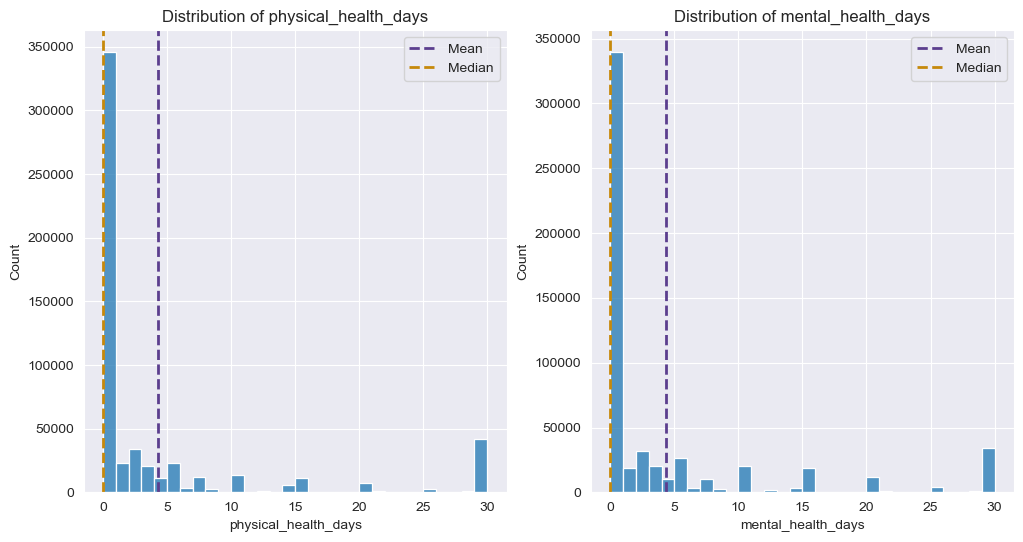

In [153]:
# Recap of physical_health_days and mental_health_days distributions
fig, axes = plt.subplots(1, 2, figsize=(12,6))

for idx, col in enumerate(nonnormal_columns):
    
    # Create the histogram
    sns.histplot(X_train[col], bins=30, ax=axes[idx])
    axes[idx].axvline(x=X_train[col].mean(), color='#5B3E8E', ls='--', lw=2, label='Mean')
    axes[idx].axvline(x=X_train[col].median(), color='#C6890B', ls='--', lw=2, label='Median')
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_ylabel(f'Count')
    axes[idx].legend()

plt.show()

In [154]:
# Instantiate Transformer
log_transformer = FunctionTransformer(func=np.log1p)

# Fit and Transform the training data
X_train[nonnormal_columns] = log_transformer.fit_transform(X_train[nonnormal_columns])

# Transform The X_test
X_test[nonnormal_columns] = log_transformer.transform(X_test[nonnormal_columns])

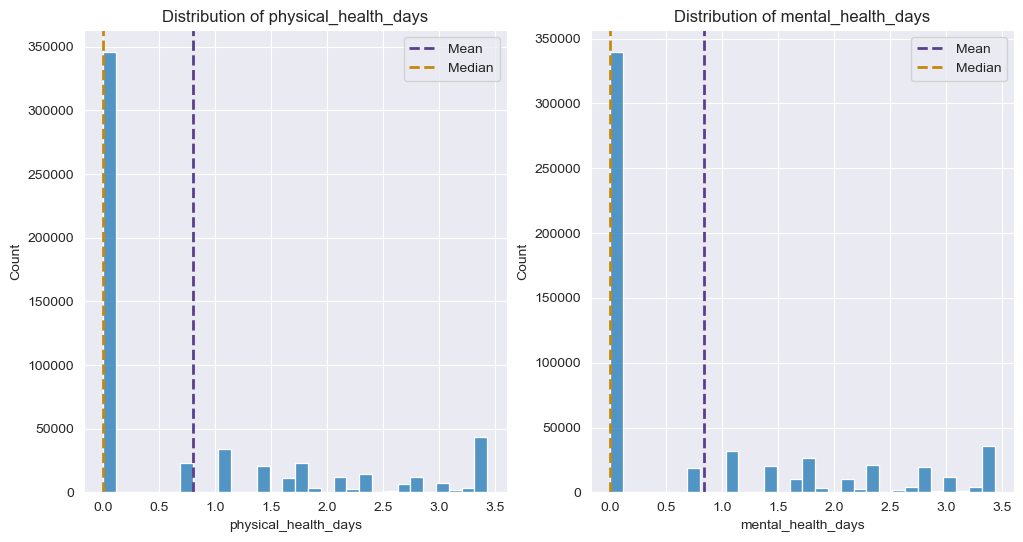

In [155]:
# Recap of physical_health_days and mental_health_days distributions
fig, axes = plt.subplots(1, 2, figsize=(12,6))

for idx, col in enumerate(nonnormal_columns):
    
    # Create the histogram
    sns.histplot(X_train[col], bins=30, ax=axes[idx])
    axes[idx].axvline(x=X_train[col].mean(), color='#5B3E8E', ls='--', lw=2, label='Mean')
    axes[idx].axvline(x=X_train[col].median(), color='#C6890B', ls='--', lw=2, label='Median')
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_ylabel(f'Count')
    axes[idx].legend()

plt.show()


Even though the distributions of `physical_health_days` and `mental_health_days` remain right-skewed after the log transformation, the data points are now more densely clustered together.

---

### 4.4 One-Hot Encoding <a class="anchor" id="4d"></a>

In [157]:
# Get the categorical and numeric columns
categorcal_columns = X_train.select_dtypes(include='object').columns.tolist()
numeric_columns = X_train.select_dtypes(include='number').columns.tolist()


In [158]:
# Calculate the sum of unique categories for all categorical columns
# Create a variable to store the cum sum and set zero
cumsum_categories = 0

for col in categorcal_columns:
    cumsum_categories += X_train[col].nunique()

print(f'Total number of categorical columns: {len(categorcal_columns)}. ')
print(f'Total number of unique categories within each categorical column: {cumsum_categories}. ')

Total number of categorical columns: 26. 
Total number of unique categories within each categorical column: 164. 


In [159]:
# Instantiate the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Fit transform the X_train categorical variables to array
encoded_array_train = encoder.fit_transform(X_train[categorcal_columns])

# Convert from arrary to DataFrame
encoded_df_train = pd.DataFrame(
    encoded_array_train, 
    columns=encoder.get_feature_names_out(categorcal_columns),
    index=X_train.index)


In [160]:
# Check encoded_df shape
print(f'After dropping one column within each categorical column, there should be 164 - 26 = {164-26} columns.')
print(f'The shape of one-hot-encoding DataFrame encoded_df: {encoded_df_train.shape}')

After dropping one column within each categorical column, there should be 164 - 26 = 138 columns.
The shape of one-hot-encoding DataFrame encoded_df: (563988, 138)


In [161]:
# Concatenate with encoded df
X_train_encoded = pd.concat([X_train[numeric_columns], encoded_df_train], axis=1)

In [162]:
# Sanity check
# Check if number of rows are consistent before and after one-hot-encoding
same_rows = (X_train.shape[0] == X_train_encoded.shape[0])

# Number of expected columns: Number of numeric columns + Number of dummy columns (after dropping one column per categorical column)
expected_column_count = len(numeric_columns) + cumsum_categories - len(categorcal_columns)
same_cols = (expected_column_count == X_train_encoded.shape[1])

# Print sanity check results
print(f'If X_train and X_train_encoded has same rows: {same_rows}')
print(f'If X_train_encoded has expected number of columns ({expected_column_count}): {same_rows}')

If X_train and X_train_encoded has same rows: True
If X_train_encoded has expected number of columns (149): True


The rows and columns on Train data after One Hot Encoding is consistent with expectations, I will now work on transformation of test data.


In [163]:
# Transform X_test
encoded_array_test = encoder.transform(X_test[categorcal_columns])

# Convert array into DataFrame
encoded_df_test = pd.DataFrame(
    encoded_array_test, 
    columns=encoder.get_feature_names_out(categorcal_columns),
    index=X_test.index
    )

# Concatenate encoded_df_test with X_test numeric columns
X_test_encoded = pd.concat([X_test[numeric_columns], encoded_df_test], axis=1)

In [164]:
# Sanity check
# Check if number of rows are consistent before and after one-hot-encoding
same_rows = (X_test.shape[0] == X_test_encoded.shape[0])

# Number of expected columns: Number of numeric columns + Number of dummy columns (after dropping one column per categorical column)
expected_column_count = len(numeric_columns) + (cumsum_categories - len(categorcal_columns))
same_cols = (expected_column_count == X_test_encoded.shape[1])

# Print sanity check results
print(f'If X_test and X_test_encoded has same rows: {same_rows}')
print(f'If X_test_encoded has expected number of columns ({expected_column_count}): {same_rows}')

If X_test and X_test_encoded has same rows: True
If X_test_encoded has expected number of columns (149): True


In [165]:
# Set X_train and X_test equal to encoded DataFrames
X_train = X_train_encoded
X_test = X_test_encoded

One hot encoding has successfully been implemented on X_trian and X_test.

---

### 4.5 Feature Scaling  <a class="anchor" id="4e"></a>

Standard scaling on original dataset.

In [167]:
# Instantiate StandardScaler
scaler = StandardScaler()

# Fit the scaler
scaler.fit(X_train)

# Transform X_train X_val X_test
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

---

### 4.6 Handling Class Imbalance  <a class="anchor" id="4f"></a>


- The target variable in this dataset is highly imbalanced, which can pose challenges during training and evaluation. In this section, I will use both upsampling and downsampling techniques to rebalance the training data.
- I will implement oversampling for Class 1 to assess its effectiveness in boosting the recall score. This approach will increase the representation of Class 1, making it the majority class at 60%

**Upsampling**

In [169]:
# Print number of class 1 and 0 sample before upsampling
print(f'Number of Class 1 samples before upsampling: {y_train.sum()}')
print(f'Number of Class 0 samples before upsampling: {y_train[y_train == 0].shape[0]}')

# Randomly duplicate class 1 observations
X_duplicate_positive, y_duplicate_positive = resample(
    X_train_scaled[y_train == 1],
    y_train[y_train == 1],
    replace=True,
    n_samples=X_train_scaled[y_train==0].shape[0],
    random_state=1
)

# Combine upsample with original data
X_train_scaled_upsampled = pd.DataFrame(
    np.vstack((X_train_scaled[y_train == 0], X_duplicate_positive)),
    columns=X_train.columns
    )

y_train_upsampled = np.hstack((y_train[y_train == 0], y_duplicate_positive))



# Print the number of class in after upsampling
print(f"\nNumber of Class 1 samples after upsampling: {y_train_upsampled.sum()}")
print(f"Number of Class 0 samples after upsampling: {y_train_upsampled.shape[0] - y_train_upsampled.sum()}")


Number of Class 1 samples before upsampling: 29762
Number of Class 0 samples before upsampling: 534226

Number of Class 1 samples after upsampling: 534226
Number of Class 0 samples after upsampling: 534226


---

**Downsampling**
#

In [172]:
# Print the number of class 0 and class 1 sample before downsampling
print(f'Number of Class 0 sample before downsampling {y_train[y_train==0].shape[0]}')
print(f'Number of Class 1 sample before downsampling {y_train.sum()}')

# Randomly remove negative class 0 observations
X_remove_negative, y_remove_negative = resample(
    X_train_scaled[y_train == 0],
    y_train[y_train == 0],
    replace=False,
    n_samples=X_train_scaled[y_train == 1].shape[0],
    random_state=1
)

# Combine downsample with original dataset
X_train_scaled_downsampled = pd.DataFrame(
    np.vstack((X_train_scaled[y_train==1], X_remove_negative)), 
    columns=X_train.columns
    )
y_train_downsampled = np.hstack((y_train[y_train == 1], y_remove_negative))

# Print the number of class in after downsampling
print(f'Number of Class 0 sample after downsampling {y_train_downsampled[y_train_downsampled==0].shape[0]}')
print(f'Number of Class 1 sample before downsampling {y_train_downsampled.sum()}')


Number of Class 0 sample before downsampling 534226
Number of Class 1 sample before downsampling 29762
Number of Class 0 sample after downsampling 29762
Number of Class 1 sample before downsampling 29762


---

**Oversampling**

In [173]:
# Print number of class 1 and 0 sample before upsampling
print(f'Number of Class 1 samples before oversampling: {y_train.sum()}')
print(f'Number of Class 0 samples before oversampling: {y_train[y_train == 0].shape[0]}')

# Randomly duplicate class 1 observations
X_duplicate_positive, y_duplicate_positive = resample(
    X_train_scaled[y_train == 1],
    y_train[y_train == 1],
    replace=True,
    n_samples=int((X_train_scaled[y_train==0].shape[0])*1.5),
    random_state=1
)

# Combine upsample with original data
X_train_scaled_oversampled = pd.DataFrame(
    np.vstack((X_train_scaled[y_train == 0], X_duplicate_positive)),
    columns=X_train.columns
    )
y_train_oversampled = np.hstack((y_train[y_train == 0], y_duplicate_positive))

# Print the number of class in after upsampling
print(f"\nNumber of Class 1 samples after upsampling: {y_train_oversampled.sum()}")
print(f"Number of Class 0 samples after upsampling: {y_train_oversampled.shape[0] - y_train_oversampled.sum()}")



Number of Class 1 samples before oversampling: 29762
Number of Class 0 samples before oversampling: 534226

Number of Class 1 samples after upsampling: 801339
Number of Class 0 samples after upsampling: 534226


---

### 4.7 Reducing Dimensionality using PCA  <a class="anchor" id="4g"></a>

In [174]:
# Get the shape of X_train
print(f'The dimension of X_train_scaled is: {X_train_scaled.shape}')

The dimension of X_train_scaled is: (563988, 149)


Find and plot the cumulative sum of variance explained by PC.

In [175]:
# Instantiate PCA with 
imbalanced_pca = PCA(n_components=0.9)

# Fit PCA
imbalanced_pca.fit(X_train_scaled)

# Transform
X_train_pca = imbalanced_pca.transform(X_train_scaled)
X_test_pca = imbalanced_pca.transform(X_test_scaled)

In [176]:
# Get the number 
num_pc = imbalanced_pca.n_components_

# Calculate the cumsum of explained variance
cumsum_pca = imbalanced_pca.explained_variance_ratio_.cumsum()

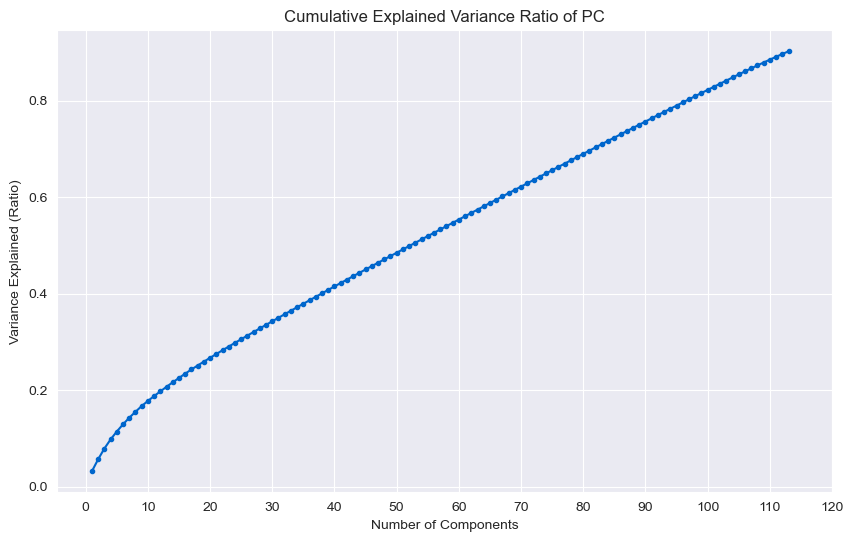

In [177]:
# Plot the cumsum of variance explained
plt.figure(figsize=(10,6))
plt.plot(range(1, num_pc+1), cumsum_pca, marker='.', c='#0066CC')
plt.title('Cumulative Explained Variance Ratio of PC')
plt.ylabel('Variance Explained (Ratio)')
plt.xlabel('Number of Components')
plt.xticks(np.arange(0, num_pc+10, 10))

plt.show()

- PCA for the upsampled Data

In [178]:
# Instantiate PCA for upsampled data
upsampled_pca = PCA(n_components=0.9)

# Fit PCA
upsampled_pca.fit(X_train_scaled_upsampled)

# Transform
X_train_pca_upsampled = upsampled_pca.transform(X_train_scaled_upsampled)
X_test_pca_upsampled = upsampled_pca.transform(X_test_scaled)

c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


- PCA for the downsampled Data

In [179]:
# Instantiate PCA for upsampled data
downsampled_pca = PCA(n_components=0.9)

# Fit PCA on the scaled downsampled training data
downsampled_pca.fit(X_train_scaled_downsampled)

# Transform both the training and test datasets using the fitted PCA
X_train_pca_downsampled = downsampled_pca.transform(X_train_scaled_downsampled)
X_test_pca_downsampled = downsampled_pca.transform(X_test_scaled)

c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


---

### 4.8 Additional preparations  <a class="anchor" id="4h"></a>

Create a function to calculate False Positive Rate (FPR)

In [180]:
# Create a function to calculate false positive rate
def false_positive_rate(y_test, y_pred):
    """"
    Calcualte the False Positive Rate
    fpr = fp / (fp + tn) where fp stands for false positives, and tn stands for true negatives

    Args:
        y_test(np.ndarray or pd.Series): True labels
        y_pred(np.ndarray or pd.Series): Predicted labels

    Returns:
        float: False positive rate
    """
    # Calculate false positives and true negatives
    fp = ((y_test == 0) & (y_pred == 1)).sum()
    tn = ((y_test == 0) & (y_pred == 0)).sum()

    # Handle edge case where sum of fp and tn is zero
    if (fp + tn) == 0:
        fpr = 0
    else: 
        # Calculate false positive rate
        fpr = round(fp / (fp + tn), 3)


    return fpr

Create two DataFrame to store the recall and false positive rate for each baseline models

In [181]:
# Create two DataFrames to store the metrics of best performer within each classification model
recall_best_model = pd.DataFrame(
    index=['Logistic Regression', 'Naive Bayes', 'Decision Tree', 'Random Forest', 'XGBoost'],
    columns=['Train', 'Test']
    )

fpr_best_model = pd.DataFrame(
    index=['Logistic Regression', 'Naive Bayes', 'Decision Tree', 'Random Forest', 'XGBoost'],
    columns=['Train', 'Test']
)

---

## 5. Baseline Modeling -  Logistic Regression <a class="anchor" id="5"></a>

### 5.1 Logistic Regression With Imbalanced Class (with class imbalance and scaling, without PCA) <a class="anchor" id="5a"></a>

Confusion matrices: 


<Figure size 300x300 with 0 Axes>

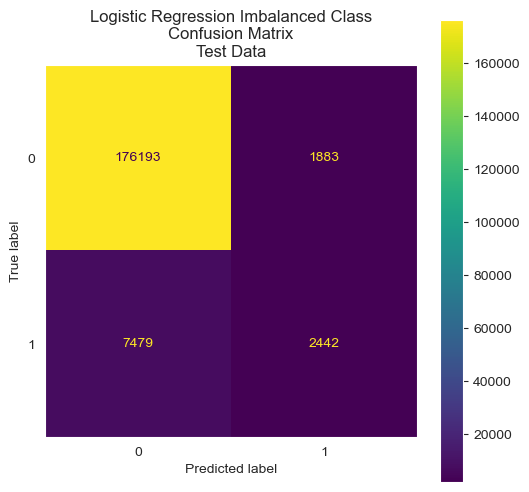

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.96      0.99      0.97    178076
           1       0.56      0.25      0.34      9921

    accuracy                           0.95    187997
   macro avg       0.76      0.62      0.66    187997
weighted avg       0.94      0.95      0.94    187997

Recall Score:
Train: 0.246
Test: 0.246 
False Positive Rate:
Train: 0.010
Test: 0.011 
Accuracy Score:
Train: 0.950
Test: 0.950 
Precision Score:
Train: 0.571
Test: 0.565 
F1 Score:
Train: 0.344
Test: 0.343 
AUC Score:
Train: 0.887
Test: 0.884 


In [205]:
###############
#MODEL FITTING#
###############

# Imbalanced Data
logit_imbalanced = LogisticRegression(max_iter=1000, random_state=42)
logit_imbalanced.fit(X_train_scaled, y_train)

# Hard Predictions for train and test data
y_pred_train = logit_imbalanced.predict(X_train_scaled)
y_pred_test = logit_imbalanced.predict(X_test_scaled)

# Predicted probabilities for train and test data
y_pred_proba_train = logit_imbalanced.predict_proba(X_train_scaled)[:, 1]
y_pred_proba_test = logit_imbalanced.predict_proba(X_test_scaled)[:, 1]


##################
#Model Evaluation#
##################

print_line = "\n" + "===========" * 6

# Confusion Matrix
print('Confusion matrices:', print_line)

# Display confusion matrices
plt.figure(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(logit_imbalanced, X_test_scaled, y_test)
plt.title('Logistic Regression Imbalanced Class\nConfusion Matrix\nTest Data')
plt.grid(False) 
plt.show()

# Print Classification Reports
report_original = classification_report(y_test, y_pred_test)
print('Test Data classification report: ', print_line, report_original)

# Print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train, y_pred_train):.3f}')
print(f'Test: {recall_score(y_test, y_pred_test):.3f}', print_line)

# Print FPR
print('False Positive Rate:')
print(f'Train: {false_positive_rate(y_train, y_pred_train):.3f}')
print(f'Test: {false_positive_rate(y_test, y_pred_test):.3f}', print_line)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train, y_pred_train):.3f}')
print(f'Test: {accuracy_score(y_test, y_pred_test):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train, y_pred_train):.3f}')
print(f'Test: {precision_score(y_test, y_pred_test):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train, y_pred_train):.3f}')
print(f'Test: {f1_score(y_test, y_pred_test):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train, y_pred_proba_train):.3f}')
print(f'Test: {roc_auc_score(y_test, y_pred_proba_test):.3f}', print_line)

---

### 5.2 Logistic Regression With Upsampling (scaled, without PCA) <a class="anchor" id="5b"></a>

c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Confusion matrices: 


<Figure size 300x300 with 0 Axes>

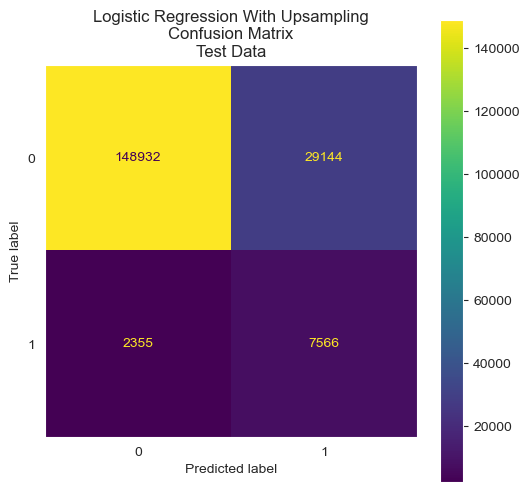

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.84      0.90    178076
           1       0.21      0.76      0.32      9921

    accuracy                           0.83    187997
   macro avg       0.60      0.80      0.61    187997
weighted avg       0.94      0.83      0.87    187997

Recall Score:
Train: 0.767
Test: 0.763 
False Positive Rate:
Train: 0.163
Test: 0.164 
Accuracy Score:
Train: 0.802
Test: 0.832 
Precision Score:
Train: 0.825
Test: 0.206 
F1 Score:
Train: 0.795
Test: 0.325 
AUC Score:
Train: 0.888
Test: 0.885 


In [297]:
###############
#MODEL FITTING#
###############

# Upsampled Data
logit_upsampled = LogisticRegression(max_iter=1000, random_state=42)
logit_upsampled.fit(X_train_scaled_upsampled, y_train_upsampled)

# Hard Predictions for train and test data
y_pred_train_upsampled = logit_upsampled.predict(X_train_scaled_upsampled)
y_pred_test = logit_upsampled.predict(X_test_scaled)

# Predicted probabilities for train and test data
y_pred_proba_train_upsampled = logit_upsampled.predict_proba(X_train_scaled_upsampled)[:, 1]
y_pred_proba_test = logit_upsampled.predict_proba(X_test_scaled)[:, 1]

##################
#Model Evaluation#
##################

print_line = "\n" + "===========" * 6

# Confusion Matrix
print('Confusion matrices:', print_line)

# Display confusion matrices
plt.figure(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(logit_upsampled, X_test_scaled, y_test)
plt.title('Logistic Regression With Upsampling\nConfusion Matrix\nTest Data')
plt.grid(False) 
plt.show()

# Print Classification Reports
report_original = classification_report(y_test, y_pred_test)
print('Test Data classification report: ', print_line, report_original)

# Print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train_upsampled, y_pred_train_upsampled):.3f}')
print(f'Test: {recall_score(y_test, y_pred_test):.3f}', print_line)

# Print FPR
print('False Positive Rate:')
print(f'Train: {false_positive_rate(y_train_upsampled, y_pred_train_upsampled):.3f}')
print(f'Test: {false_positive_rate(y_test, y_pred_test):.3f}', print_line)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train_upsampled, y_pred_train_upsampled):.3f}')
print(f'Test: {accuracy_score(y_test, y_pred_test):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train_upsampled, y_pred_train_upsampled):.3f}')
print(f'Test: {precision_score(y_test, y_pred_test):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train_upsampled, y_pred_train_upsampled):.3f}')
print(f'Test: {f1_score(y_test, y_pred_test):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train_upsampled, y_pred_proba_train_upsampled):.3f}')
print(f'Test: {roc_auc_score(y_test, y_pred_proba_test):.3f}', print_line)

In [298]:
# Since this is the best performer, store the metrics in the DataFrame
recall_best_model.loc['Logistic Regression', :] = [
    recall_score(y_train_upsampled, y_pred_train_upsampled).round(3), 
    recall_score(y_test, y_pred_test).round(3)
    ]

fpr_best_model.loc['Logistic Regression', :] = [
    false_positive_rate(y_train_upsampled, y_pred_train_upsampled).round(3), 
    false_positive_rate(y_test, y_pred_test).round(3)
    ]


---

#### Model Interpretation

- In logistic regression, a feature with the greatest positive coefficient has the most predictive power for predicting the positive class, while a feature with a significant negative coefficient indicates a greater likelihood of predicting the negative class.
- In this section, I will interpret the top 15 features that have the greatest predictive power for experiencing a heart attack (Class 1), as well as the top 15 features for not experiencing a heart attack (Class 0). Specifically, I will:

    1. Generate a sorted list of the 15 features with their coefficients, ordered from highest to lowest.
    2. Generate a sorted list of the 15 features with their coefficients (negative numbers), ordered from lowest to highest.
    3. Visualize the top 15 features from each list.

In [299]:
# Fetch the coefficients and corresponding feature name
logit_upsampled_coefficients = pd.Series(logit_upsampled.coef_[0], index=X_train_encoded.columns)

In [300]:
# Find the top 15 and bottom 15 features that predicting a heart attack
top15_coef = logit_upsampled_coefficients.sort_values(ascending=False).head(15)
bottom15_coef = logit_upsampled_coefficients.sort_values().head(15)

In [301]:
# Create a list to store all the important features in logreg
logreg_important_features = top15_coef.index.tolist() + bottom15_coef.index.tolist()

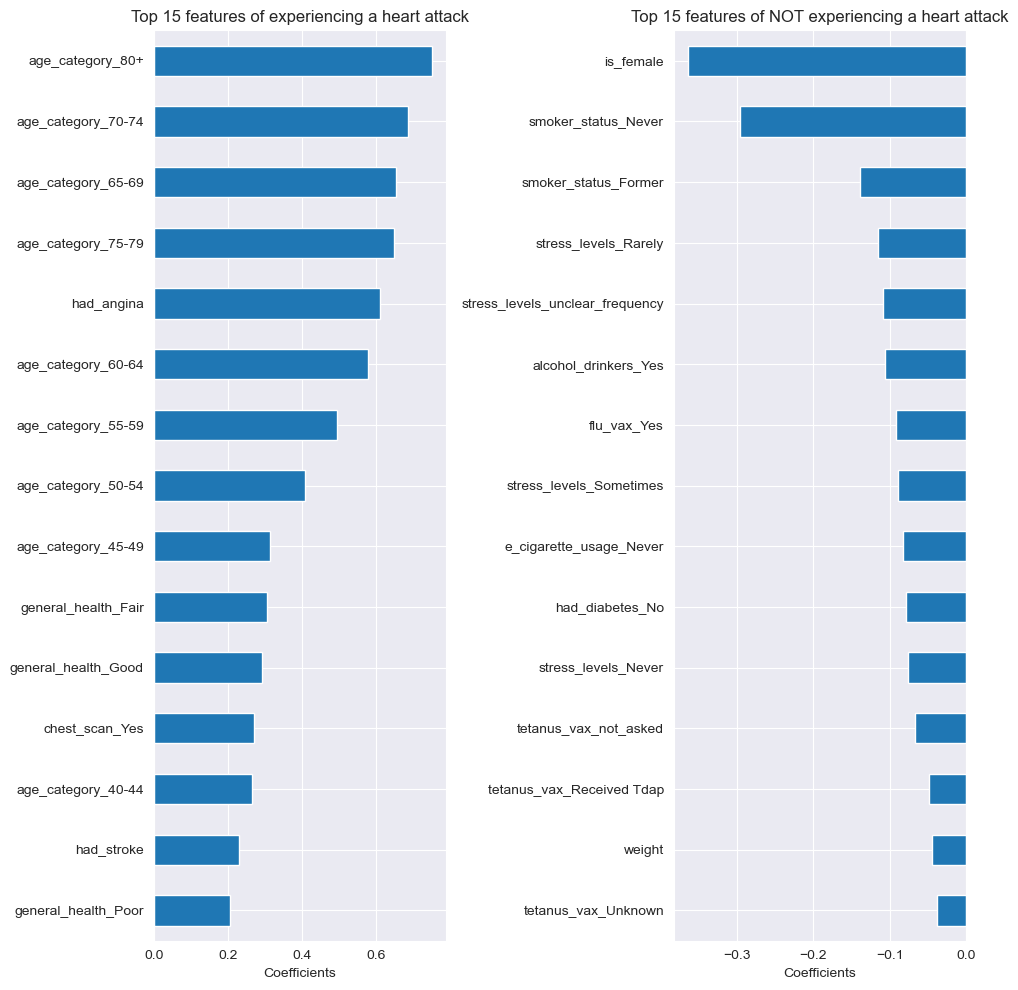

In [302]:
# Instantiate a subplot
fig, axes = plt.subplots(1, 2 , figsize=(10, 10))

# Create the plot of 15 largest coefficients
top15_coef.sort_values().plot(kind='barh', legend=False, ax=axes[0])
axes[0].set_title('Top 15 features of experiencing a heart attack')
axes[0].set_xlabel('Coefficients')


# Create the plot of 20 smallest coefficients
bottom15_coef.sort_values(ascending=False).plot(kind='barh', legend=False, ax=axes[1])
axes[1].set_title('Top 15 features of NOT experiencing a heart attack')
axes[1].set_xlabel('Coefficients')

plt.tight_layout()
plt.show()

In [303]:
# get the largest positive coefficient, and calculate the odds
print(f'Top predictive feature of positive instance: {top15_coef.index[0]}')
print(f'Coefficient: {top15_coef.values[0]}')
print(f'Odds: {np.exp(top15_coef.values[0]):.2f}')

Top predictive feature of positive instance: age_category_80+
Coefficient: 0.7521537423213205
Odds: 2.12


In [304]:
# get the smallest negative coefficient, and calculate the odds
print(f'Top predictive feature of negative instance: {bottom15_coef.index[0]}')
print(f'Coefficient: {bottom15_coef.values[0]}')
print(f'Odds: {np.exp(bottom15_coef.values[0]):.2f}')

Top predictive feature of negative instance: is_female
Coefficient: -0.36417193637058054
Odds: 0.69


**Coefficient Interpretation:**<br>
Top predictive word in having a heart attack and not having a heart attack:
| Parameter                   | Coefficient   | Calculation     | Result | Interpretation                                                                 |
|:----------------------------|:--------------|:----------------|:-------|:------------------------------------------------------------------------------|
| **age_category_80+**    | 0.75         | $e^{0.75}$   | 2.12  | Individuals whose age is 80+ have much higher odds of having a heart attack. One standard deviation increase in the presence of age 80+ will lead to an approximate odds increase of 2.12 times. |
| **is_female**    | -0.36      | $e^{-0.36}$   | 0.69  | Femalse has a lower odds of experiencing a heart attack. One standard deviation increase in the presence of female will lead to an approximate decrease of 0.69 times.  |


---

---

### 5.3 Logistic Regression With Downsampling (scaled, without PCA) <a class="anchor" id="5c"></a>

Confusion matrices: 


c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


<Figure size 500x500 with 0 Axes>

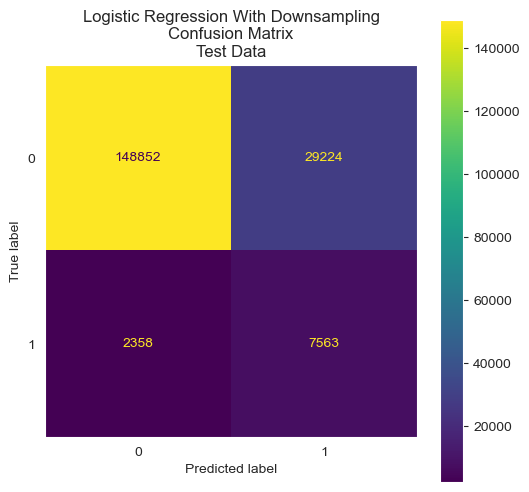

Test Data Classification Report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.84      0.90    178076
           1       0.21      0.76      0.32      9921

    accuracy                           0.83    187997
   macro avg       0.59      0.80      0.61    187997
weighted avg       0.94      0.83      0.87    187997

Recall Score:
Train: 0.767
Test: 0.762 
False Positive Rate:
Train: 0.161
Test: 0.164 
Accuracy Score:
Train: 0.803
Test: 0.832 
Precision Score:
Train: 0.826
Test: 0.206 
F1 Score:
Train: 0.795
Test: 0.324 
AUC Score:
Train: 0.888
Test: 0.884 


In [206]:
###############
# MODEL FITTING #
###############

# Downsampled Data
logit_downsampled = LogisticRegression(max_iter=1000, random_state=42)
logit_downsampled.fit(X_train_scaled_downsampled, y_train_downsampled)

# Hard Predictions for train and test data
y_pred_train_downsampled = logit_downsampled.predict(X_train_scaled_downsampled)
y_pred_test = logit_downsampled.predict(X_test_scaled)

# Predicted probabilities for train and test data
y_pred_proba_train_downsampled = logit_downsampled.predict_proba(X_train_scaled_downsampled)[:, 1]
y_pred_proba_test = logit_downsampled.predict_proba(X_test_scaled)[:, 1]

##################
# MODEL EVALUATION #
##################

print_line = "\n" + "===========" * 6

# Confusion Matrix
print('Confusion matrices:', print_line)

# Display confusion matrix for the test data
plt.figure(figsize=(3, 3))  # Adjusted size for better visibility
ConfusionMatrixDisplay.from_estimator(logit_downsampled, X_test_scaled, y_test)
plt.title('Logistic Regression With Downsampling\nConfusion Matrix\nTest Data')
plt.grid(False) 
plt.show()

# Print Classification Reports
report_original = classification_report(y_test, y_pred_test)
print('Test Data Classification Report: ', print_line, report_original)

# Print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train_downsampled, y_pred_train_downsampled):.3f}')
print(f'Test: {recall_score(y_test, y_pred_test):.3f}', print_line)

# Print False Positive Rate
print('False Positive Rate:')
print(f'Train: {false_positive_rate(y_train_downsampled, y_pred_train_downsampled):.3f}')
print(f'Test: {false_positive_rate(y_test, y_pred_test):.3f}', print_line)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train_downsampled, y_pred_train_downsampled):.3f}')
print(f'Test: {accuracy_score(y_test, y_pred_test):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train_downsampled, y_pred_train_downsampled):.3f}')
print(f'Test: {precision_score(y_test, y_pred_test):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train_downsampled, y_pred_train_downsampled):.3f}')
print(f'Test: {f1_score(y_test, y_pred_test):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train_downsampled, y_pred_proba_train_downsampled):.3f}')
print(f'Test: {roc_auc_score(y_test, y_pred_proba_test):.3f}', print_line)

---

### 5.4 Logistic Regression With Oversampling (scaled, without PCA) <a class="anchor" id="5d"></a>

c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Confusion matrices: 


c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


<Figure size 500x500 with 0 Axes>

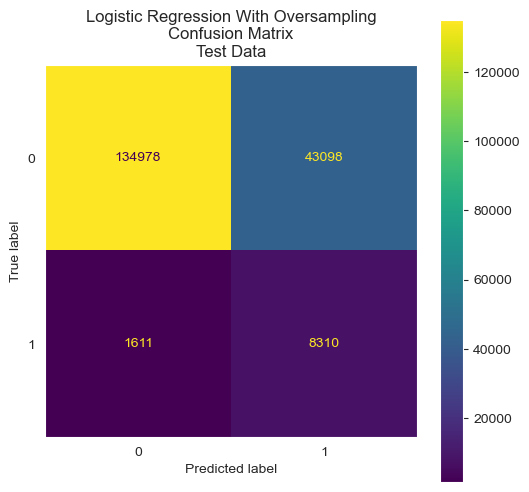

Test Data Classification Report:  
==================================================================               precision    recall  f1-score   support

           0       0.99      0.76      0.86    178076
           1       0.16      0.84      0.27      9921

    accuracy                           0.76    187997
   macro avg       0.57      0.80      0.56    187997
weighted avg       0.94      0.76      0.83    187997

Recall Score:
Train: 0.843
Test: 0.838 
False Positive Rate:
Train: 0.242
Test: 0.242 
Accuracy Score:
Train: 0.809
Test: 0.762 
Precision Score:
Train: 0.839
Test: 0.162 
F1 Score:
Train: 0.841
Test: 0.271 
AUC Score:
Train: 0.888
Test: 0.885 


In [207]:
###############
# MODEL FITTING #
###############

# Oversampled Data
logit_oversampled = LogisticRegression(max_iter=1000, random_state=42)
logit_oversampled.fit(X_train_scaled_oversampled, y_train_oversampled)

# Hard Predictions for train and test data
y_pred_train_oversampled = logit_oversampled.predict(X_train_scaled_oversampled)
y_pred_test = logit_oversampled.predict(X_test_scaled)

# Predicted probabilities for train and test data
y_pred_proba_train_oversampled = logit_oversampled.predict_proba(X_train_scaled_oversampled)[:, 1]
y_pred_proba_test = logit_oversampled.predict_proba(X_test_scaled)[:, 1]

##################
# MODEL EVALUATION #
##################

print_line = "\n" + "===========" * 6

# Confusion Matrix
print('Confusion matrices:', print_line)

# Display confusion matrix for the test data
plt.figure(figsize=(3, 3))  # Adjusted size for better visibility
ConfusionMatrixDisplay.from_estimator(logit_oversampled, X_test_scaled, y_test)
plt.title('Logistic Regression With Oversampling\nConfusion Matrix\nTest Data')
plt.grid(False) 
plt.show()

# Print Classification Reports
report_original = classification_report(y_test, y_pred_test)
print('Test Data Classification Report: ', print_line, report_original)

# Print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train_oversampled, y_pred_train_oversampled):.3f}')
print(f'Test: {recall_score(y_test, y_pred_test):.3f}', print_line)

# Print False Positive Rate
print('False Positive Rate:')
print(f'Train: {false_positive_rate(y_train_oversampled, y_pred_train_oversampled):.3f}')
print(f'Test: {false_positive_rate(y_test, y_pred_test):.3f}', print_line)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train_oversampled, y_pred_train_oversampled):.3f}')
print(f'Test: {accuracy_score(y_test, y_pred_test):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train_oversampled, y_pred_train_oversampled):.3f}')
print(f'Test: {precision_score(y_test, y_pred_test):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train_oversampled, y_pred_train_oversampled):.3f}')
print(f'Test: {f1_score(y_test, y_pred_test):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train_oversampled, y_pred_proba_train_oversampled):.3f}')
print(f'Test: {roc_auc_score(y_test, y_pred_proba_test):.3f}', print_line)

- While the model shows an improvement in the Recall score compared to other methods, it exhibits signs of overfitting, as evidenced by a notably lower accuracy score on the test set relative to the training accuracy. Consequently, oversampling does not appear to be an effective method for enhancing model performance.

---

### 5.5 Best Model with PCA - Logistic Regression With Upsampling and PCA <a class="anchor" id="5e"></a>

Confusion matrices: 


<Figure size 300x300 with 0 Axes>

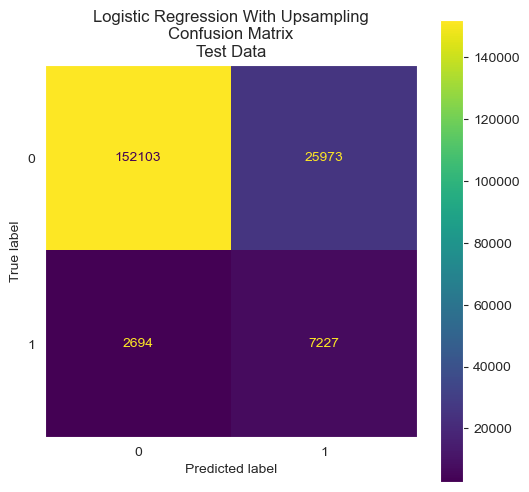

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.85      0.91    178076
           1       0.22      0.73      0.34      9921

    accuracy                           0.85    187997
   macro avg       0.60      0.79      0.62    187997
weighted avg       0.94      0.85      0.88    187997

Recall Score:
Train: 0.735
Test: 0.728 
False Positive Rate:
Train: 0.146
Test: 0.146 
Accuracy Score:
Train: 0.795
Test: 0.848 
Precision Score:
Train: 0.834
Test: 0.218 
F1 Score:
Train: 0.782
Test: 0.335 
AUC Score:
Train: 0.888
Test: 0.791 


In [213]:
###############
#MODEL FITTING#
###############

# Upsampled Data
logit_upsampled_pca = LogisticRegression(max_iter=1000, random_state=42)
logit_upsampled_pca.fit(X_train_pca_upsampled, y_train_upsampled)

# Hard Predictions for train and test data
y_pred_train_upsampled_pca = logit_upsampled_pca.predict(X_train_pca_upsampled)
y_pred_test_pca = logit_upsampled_pca.predict(X_test_pca_upsampled)

# Predicted probabilities for train and test data
y_pred_proba_train_upsampled_pca = logit_upsampled_pca.predict_proba(X_train_pca_upsampled)[:, 1]
y_pred_proba_test_pca = logit_upsampled_pca.predict_proba(X_test_pca_upsampled)[:, 1]

##################
#Model Evaluation#
##################

print_line = "\n" + "===========" * 6

# Confusion Matrix
print('Confusion matrices:', print_line)

# Display confusion matrices
plt.figure(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(logit_upsampled_pca, X_test_pca_upsampled, y_test)
plt.title('Logistic Regression With Upsampling\nConfusion Matrix\nTest Data')
plt.grid(False) 
plt.show()

# Print Classification Reports
report_original = classification_report(y_test, y_pred_test_pca)
print('Test Data classification report: ', print_line, report_original)

# Print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train_upsampled, y_pred_train_upsampled_pca):.3f}')
print(f'Test: {recall_score(y_test, y_pred_test_pca):.3f}', print_line)

# Print FPR
print('False Positive Rate:')
print(f'Train: {false_positive_rate(y_train_upsampled, y_pred_train_upsampled_pca):.3f}')
print(f'Test: {false_positive_rate(y_test, y_pred_test_pca):.3f}', print_line)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train_upsampled, y_pred_train_upsampled_pca):.3f}')
print(f'Test: {accuracy_score(y_test, y_pred_test_pca):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train_upsampled, y_pred_train_upsampled_pca):.3f}')
print(f'Test: {precision_score(y_test, y_pred_test_pca):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train_upsampled, y_pred_train_upsampled_pca):.3f}')
print(f'Test: {f1_score(y_test, y_pred_test_pca):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train_upsampled, y_pred_proba_train_upsampled):.3f}')
print(f'Test: {roc_auc_score(y_test, y_pred_test_pca):.3f}', print_line)

---

### 5.6 Logistic Regression Baseline Modeling Summary <a class="anchor" id="5f"></a>

**Metrics using test data:**
| Model                   | PCA | Recall | FPR  | Accuracy | Precision | F1 Score | AUC   | Notes                                             |
|-------------------------|-----|--------|------|----------|-----------|----------|-------|---------------------------------------------------|
| Logistic Regression      | No  | 0.246  | 0.011| 0.950    | 0.565     | 0.343    | 0.884 | Imbalanced                                        |
| **Logistic Regression**      | No  | **0.763**  | **0.164** | 0.832    | 0.206     | 0.325    | 0.885 | **Upsampled**                                      |
| Logistic Regression      | No  | 0.762  | 0.164 | 0.832    | 0.206     | 0.324    | 0.884 | Downsampled                                       |
| Logistic Regression      | No  | 0.838  | 0.242 | 0.762    | 0.162     | 0.271    | 0.885 | Oversampled (60% Class 1), Overfitting in accuracy   |
| Logistic Regression      | Yes | 0.728  | 0.146 | 0.848    | 0.218     | 0.335    | 0.791  | Upsampled, PCA set at n_components=0.9          |



- By far, hyperparameter tuning has not been performed on any of the Logistic Regression models. The models utilizing upsampling and downsampling demonstrate very similar performance, with the upsampling model achieving slightly better recall metrics.

- After applying oversampling to increase the number of Class 1 (heart attack) observations, Class 1 now comprises 60% of the labels in the training set. This adjustment resulted in a 7.5% improvement in the recall score. However, it also led to a 7.8% increase in the false positive rate. Additionally, indications of overfitting were observed, as evidenced by a noticeable gap between the accuracy on the training data and the accuracy on the test data.

- The model with PCA performed worse than the best performer, suggesting that the features may contain important non-linear relationships that PCA fails to capture. Consequently, valuable information may have been lost during the dimensionality reduction process.

- All models trained on balanced datasets (upsampling, downsampling, oversampling) exhibit a significant gap in the precision score between training and test data. This discrepancy may be attributed to overfitting, especially given that the baseline models consist of 149 features. Additionally, the imbalance distribution in the test set plays a critical role. Recall the formula for $\text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}}$. In the test set, where negatives comprise 94.7% of the data, even a small false positive rate can result in a substantial number of false positives. This increase in false positives ultimately reduces the precision score, causing the discrepancy in train and test precision.

---

## 6 Baseline Modeling - Naive Bayes  <a class="anchor" id="6"></a>

### 6.1 Naive Bayes With Imbalanced Class (with class imbalance and scaling, without PCA) <a class="anchor" id="6a"></a>

Confusion matrices: 


<Figure size 300x300 with 0 Axes>

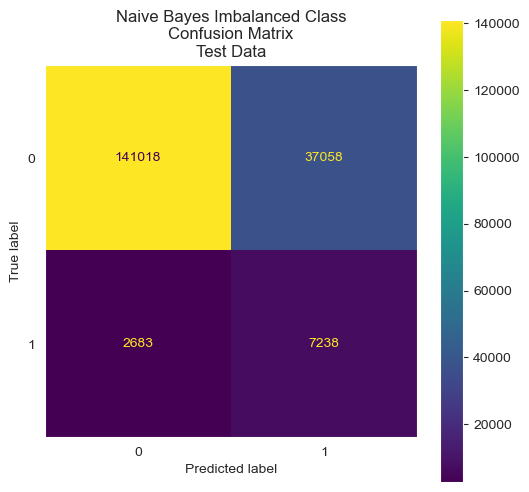

Recall Score:
Train: 0.733
Test: 0.730 
False Positive Rate:
Train: 0.209
Test: 0.208 
Accuracy Score:
Train: 0.788
Test: 0.789 
Precision Score:
Train: 0.163
Test: 0.163 
F1 Score:
Train: 0.267
Test: 0.267 
AUC Score:
Train: 0.826
Test: 0.824 


In [228]:
###############
#MODEL FITTING#
###############

# Imbalanced Data
nbmodel_imbalanced = GaussianNB()
nbmodel_imbalanced.fit(X_train_scaled, y_train)

# Hard Predictions for train and test data
y_pred_train = nbmodel_imbalanced.predict(X_train_scaled)
y_pred_test = nbmodel_imbalanced.predict(X_test_scaled)


# Predicted probabilities for train and test data
y_pred_proba_train = nbmodel_imbalanced.predict_proba(X_train_scaled)[:, 1]
y_pred_proba_test = nbmodel_imbalanced.predict_proba(X_test_scaled)[:, 1]


##################
#Model Evaluation#
##################

print_line = "\n" + "===========" * 6

# Confusion Matrix
print('Confusion matrices:', print_line)

# Display confusion matrices
plt.figure(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(nbmodel_imbalanced, X_test_scaled, y_test)
plt.title('Naive Bayes Imbalanced Class\nConfusion Matrix\nTest Data')
plt.grid(False) 
plt.show()

# Print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train, y_pred_train):.3f}')
print(f'Test: {recall_score(y_test, y_pred_test):.3f}', print_line)

# Print FPR
print('False Positive Rate:')
print(f'Train: {false_positive_rate(y_train, y_pred_train):.3f}')
print(f'Test: {false_positive_rate(y_test, y_pred_test):.3f}', print_line)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train, y_pred_train):.3f}')
print(f'Test: {accuracy_score(y_test, y_pred_test):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train, y_pred_train):.3f}')
print(f'Test: {precision_score(y_test, y_pred_test):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train, y_pred_train):.3f}')
print(f'Test: {f1_score(y_test, y_pred_test):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train, y_pred_proba_train):.3f}')
print(f'Test: {roc_auc_score(y_test, y_pred_proba_test):.3f}', print_line)

In [229]:
# Since this is the best performer, store the metrics in the DataFrame
recall_best_model.loc['Naive Bayes', :] = [
    recall_score(y_train, y_pred_train).round(3), 
    recall_score(y_test, y_pred_test).round(3)
    ]

fpr_best_model.loc['Naive Bayes', :] = [
    false_positive_rate(y_train, y_pred_train).round(3), 
    false_positive_rate(y_test, y_pred_test).round(3)
    ]

---

### 6.2 Naive Bayes With Upsampling (scaled, without PCA) <a class="anchor" id="6b"></a>

c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


Confusion matrices: 


c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


<Figure size 300x300 with 0 Axes>

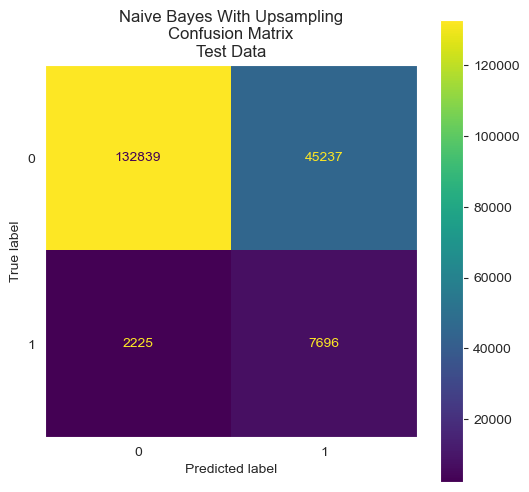

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.75      0.85    178076
           1       0.15      0.78      0.24      9921

    accuracy                           0.75    187997
   macro avg       0.56      0.76      0.55    187997
weighted avg       0.94      0.75      0.82    187997

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.75      0.85    178076
           1       0.15      0.78      0.24      9921

    accuracy                           0.75    187997
   macro avg       0.56      0.76      0.55    187997
weighted avg       0.94      0.75      0.82    187997

Recall Score:
Train: 0.767
Test: 0.776 
False Positive Rate:
Train: 0.163
Test: 0.254 
Accuracy Score:
Train: 0.802
Test: 0.748 
Precision Sco

In [215]:
###############
#MODEL FITTING#
###############

# Upsampled Data
nbmodel_upsampled = GaussianNB()
nbmodel_upsampled.fit(X_train_scaled_upsampled, y_train_upsampled)

# Hard Predictions for train and test data
y_pred_train = nbmodel_upsampled.predict(X_train_scaled_upsampled)
y_pred_test = nbmodel_upsampled.predict(X_test_scaled)

# Calculate predicted probabilities for train and test
y_pred_proba_train = nbmodel_upsampled.predict_proba(X_train_scaled_upsampled)[:, 1]
y_pred_proba_test = nbmodel_upsampled.predict_proba(X_test_scaled)[:, 1]

##################
#Model Evaluation#
##################

print_line = "\n" + "===========" * 6

# Confusion Matrix
print('Confusion matrices:', print_line)

# Display confusion matrices
plt.figure(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(nbmodel_upsampled, X_test_scaled, y_test)
plt.title('Naive Bayes With Upsampling\nConfusion Matrix\nTest Data')
plt.grid(False) 
plt.show()

# Print Classification Reports
report_original = classification_report(y_test, y_pred_test)
print('Test Data classification report: ', print_line, report_original)

# Print Classification Reports
report_original = classification_report(y_test, y_pred_test)
print('Test Data classification report: ', print_line, report_original)

# Print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train_upsampled, y_pred_train_upsampled):.3f}')
print(f'Test: {recall_score(y_test, y_pred_test):.3f}', print_line)

# Print FPR
print('False Positive Rate:')
print(f'Train: {false_positive_rate(y_train_upsampled, y_pred_train_upsampled):.3f}')
print(f'Test: {false_positive_rate(y_test, y_pred_test):.3f}', print_line)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train_upsampled, y_pred_train_upsampled):.3f}')
print(f'Test: {accuracy_score(y_test, y_pred_test):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train_upsampled, y_pred_train_upsampled):.3f}')
print(f'Test: {precision_score(y_test, y_pred_test):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train_upsampled, y_pred_train_upsampled):.3f}')
print(f'Test: {f1_score(y_test, y_pred_test):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train_upsampled, y_pred_proba_train_upsampled):.3f}')
print(f'Test: {roc_auc_score(y_test, y_pred_proba_test):.3f}', print_line)

---

#### 6.3 Naive Bayes With Downsampling (scaled, without PCA) <a class="anchor" id="6c"></a>

c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


Confusion Matrix: 


c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


<Figure size 300x300 with 0 Axes>

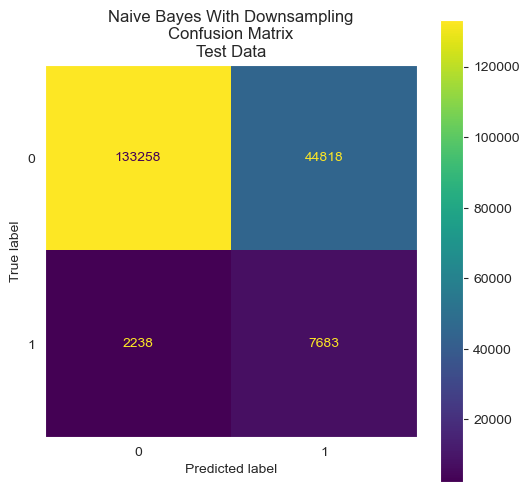

Test Data Classification Report: 
==================================================================               precision    recall  f1-score   support

           0       0.98      0.75      0.85    178076
           1       0.15      0.77      0.25      9921

    accuracy                           0.75    187997
   macro avg       0.56      0.76      0.55    187997
weighted avg       0.94      0.75      0.82    187997

Recall Score:
Train: 0.767
Test: 0.774 
False Positive Rate:
Train: 0.161
Test: 0.252 
Accuracy Score:
Train: 0.803
Test: 0.750 
Precision Score:
Train: 0.826
Test: 0.146 
F1 Score:
Train: 0.795
Test: 0.246 
AUC Score:
Train: 0.888
Test: 0.823 


In [216]:
###############
# MODEL FITTING #
###############

# Instantiate and fit Gaussian Naive Bayes on Downsampled Data
nbmodel_downsampled = GaussianNB()
nbmodel_downsampled.fit(X_train_scaled_downsampled, y_train_downsampled)

# Hard Predictions for train and test data
y_pred_train = nbmodel_downsampled.predict(X_train_scaled_downsampled)
y_pred_test = nbmodel_downsampled.predict(X_test_scaled)

# Predicted probabilities for train and test data
y_pred_proba_train = nbmodel_downsampled.predict_proba(X_train_scaled_downsampled)[:, 1]
y_pred_proba_test = nbmodel_downsampled.predict_proba(X_test_scaled)[:, 1]

##################
# MODEL EVALUATION #
##################

print_line = "\n" + "===========" * 6

# Confusion Matrix
print('Confusion Matrix:', print_line)

# Display confusion matrices
plt.figure(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(nbmodel_downsampled, X_test_scaled, y_test)
plt.title('Naive Bayes With Downsampling\nConfusion Matrix\nTest Data')
plt.grid(False) 
plt.show()

# Print Classification Report
report_original = classification_report(y_test, y_pred_test)
print('Test Data Classification Report:', print_line, report_original)

# Print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train_downsampled, y_pred_train_downsampled):.3f}')
print(f'Test: {recall_score(y_test, y_pred_test):.3f}', print_line)

# Print False Positive Rate
print('False Positive Rate:')
print(f'Train: {false_positive_rate(y_train_downsampled, y_pred_train_downsampled):.3f}')
print(f'Test: {false_positive_rate(y_test, y_pred_test):.3f}', print_line)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train_downsampled, y_pred_train_downsampled):.3f}')
print(f'Test: {accuracy_score(y_test, y_pred_test):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train_downsampled, y_pred_train_downsampled):.3f}')
print(f'Test: {precision_score(y_test, y_pred_test):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train_downsampled, y_pred_train_downsampled):.3f}')
print(f'Test: {f1_score(y_test, y_pred_test):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train_downsampled, y_pred_proba_train_downsampled):.3f}')
print(f'Test: {roc_auc_score(y_test, y_pred_proba_test):.3f}', print_line)

---

### 6.4 Naive Bayes Baseline Modeling Summary <a class="anchor" id="6d"></a>

**Metrics using test data:**
| Model                   | PCA | Recall | FPR  | Accuracy | Precision | F1 Score | AUC   | Notes                       |
|-------------------------|-----|--------|------|----------|-----------|----------|-------|-----------------------------|
| **Naive Bayes**             | No  | **0.730**  | **0.208**| 0.789    | 0.163     | 0.267    | 0.824 | **Imbalanced**                 |
| Naive Bayes             | No  | 0.776  | 0.254| 0.748    | 0.145     | 0.245    | 0.824 | Upsampled, Overfitting     |
| Naive Bayes         | No| 0.774| 0.252| 0.750| 0.146| 0.246| 0.823 | Downsampled, Overfitting |

- By far, hyperparameter tuning has not been performed on any of the Naive Bayes models. The models utilizing upsampling and downsampling demonstrate very similar performance, with the downsampling model achieving slightly better Recall metrics.
- Both models with upsampling and downsampling exhibit sign of overfitting, where the accuracy and false positive rate on the test data underperforms compared to the scores on the train data, so feature selection should be performed later to improve generalization.
- Compared to the imbalanced Logistic Regression model, the Naive Bayes model demonstrates a significantly higher Recall score at the expense of Accuracy and Precision. This can be attributed to the fundamental nature of Naive Bayes, which calculates probabilities based on class distributions, allowing for better identification of the minority class in the context of an imbalanced distribution.
- Surprisingly, the best performer among the Naive Bayes models is the one trained on imbalanced data. While it underperforms in recall by 4.6% compared to other models, it achieves a lower false positive rate (FPR) of 4.6% and does not show signs of overfitting.


---



## 7 Baseline Modeling - Decision Tree  <a class="anchor" id="7"></a>

### 7.1 Decision Tree Imbalanced (with class imbalance and scaling, without PCA) <a class="anchor" id="7a"></a>

Confusion Matrix: 


<Figure size 300x300 with 0 Axes>

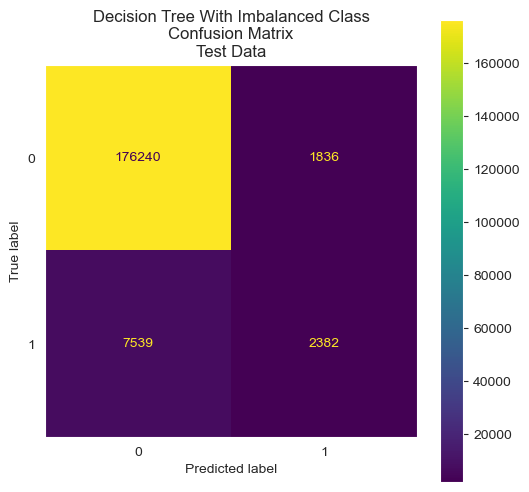

Test Data Classification Report: 
==================================================================               precision    recall  f1-score   support

           0       0.96      0.99      0.97    178076
           1       0.56      0.24      0.34      9921

    accuracy                           0.95    187997
   macro avg       0.76      0.61      0.66    187997
weighted avg       0.94      0.95      0.94    187997

Recall Score:
Train: 0.246
Test: 0.240 
False Positive Rate:
Train: 0.010
Test: 0.010 
Accuracy Score:
Train: 0.951
Test: 0.950 
Precision Score:
Train: 0.589
Test: 0.565 
F1 Score:
Train: 0.347
Test: 0.337 
AUC Score:
Train: 0.859
Test: 0.855 


In [232]:
###############
# MODEL FITTING #
###############

# Fit Decision Tree Classifier on Imbalanced Data
dt_imbalanced = DecisionTreeClassifier(max_depth=7, random_state=42)
dt_imbalanced.fit(X_train_scaled, y_train)  # Using the original scaled data

# Hard Predictions for train and test data
y_pred_train = dt_imbalanced.predict(X_train_scaled)
y_pred_test = dt_imbalanced.predict(X_test_scaled)

# Predicted probabilities for train and test data
y_pred_proba_train = dt_imbalanced.predict_proba(X_train_scaled)[:, 1]
y_pred_proba_test = dt_imbalanced.predict_proba(X_test_scaled)[:, 1]

##################
# MODEL EVALUATION #
##################

print_line = "\n" + "===========" * 6

# Display Confusion Matrix
print('Confusion Matrix:', print_line)
plt.figure(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(dt_imbalanced, X_test_scaled, y_test)
plt.title('Decision Tree With Imbalanced Class\nConfusion Matrix\nTest Data')
plt.grid(False) 
plt.show()

# Print Classification Report
report_original = classification_report(y_test, y_pred_test)
print('Test Data Classification Report:', print_line, report_original)

# Print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train, y_pred_train):.3f}')
print(f'Test: {recall_score(y_test, y_pred_test):.3f}', print_line)

# Print FPR
print('False Positive Rate:')
print(f'Train: {false_positive_rate(y_train, y_pred_train):.3f}')
print(f'Test: {false_positive_rate(y_test, y_pred_test):.3f}', print_line)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train, y_pred_train):.3f}')
print(f'Test: {accuracy_score(y_test, y_pred_test):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train, y_pred_train):.3f}')
print(f'Test: {precision_score(y_test, y_pred_test):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train, y_pred_train):.3f}')
print(f'Test: {f1_score(y_test, y_pred_test):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train, y_pred_proba_train):.3f}')
print(f'Test: {roc_auc_score(y_test, y_pred_proba_test):.3f}', print_line)

---

### 7.2 Decision Tree With Upsampling (scaled, without PCA) <a class="anchor" id="7b"></a>

c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Confusion matrices: 


c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


<Figure size 300x300 with 0 Axes>

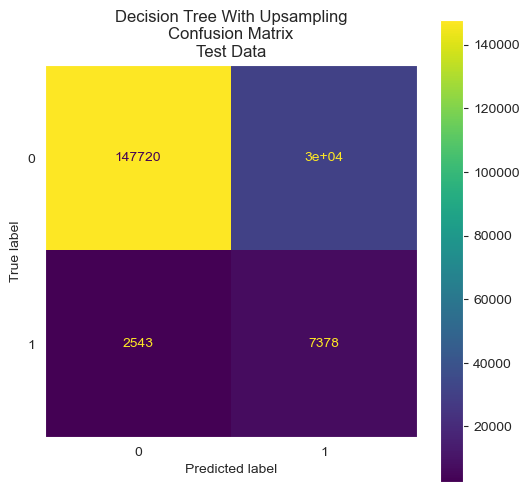

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.83      0.90    178076
           1       0.20      0.74      0.31      9921

    accuracy                           0.83    187997
   macro avg       0.59      0.79      0.60    187997
weighted avg       0.94      0.83      0.87    187997

Recall Score:
Train: 0.767
Test: 0.744 
False Positive Rate:
Train: 0.163
Test: 0.170 
Accuracy Score:
Train: 0.802
Test: 0.825 
Precision Score:
Train: 0.825
Test: 0.196 
F1 Score:
Train: 0.795
Test: 0.310 
AUC Score:
Train: 0.888
Test: 0.856 


In [240]:
###############
#MODEL FITTING#
###############

# Upsampled Data
dt_upsampled = DecisionTreeClassifier(max_depth=7, random_state=42)
dt_upsampled.fit(X_train_scaled_upsampled, y_train_upsampled)

# Hard Predictions for train and test data
y_pred_train = dt_upsampled.predict(X_train_scaled_upsampled)
y_pred_test = dt_upsampled.predict(X_test_scaled)

# Predicted probabilities for train and test data
y_pred_proba_train = dt_upsampled.predict_proba(X_train_scaled_upsampled)[:, 1]
y_pred_proba_test = dt_upsampled.predict_proba(X_test_scaled)[:, 1]

##################
#Model Evaluation#
##################

print_line = "\n" + "===========" * 6

# Confusion Matrix
print('Confusion matrices:', print_line)

# Display confusion matrices
plt.figure(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(dt_upsampled, X_test_scaled, y_test)
plt.title('Decision Tree With Upsampling\nConfusion Matrix\nTest Data')
plt.grid(False) 
plt.show()

# Print Classification Reports
report_original = classification_report(y_test, y_pred_test)
print('Test Data classification report: ', print_line, report_original)

# Print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train_upsampled, y_pred_train_upsampled):.3f}')
print(f'Test: {recall_score(y_test, y_pred_test):.3f}', print_line)

# Print FPR
print('False Positive Rate:')
print(f'Train: {false_positive_rate(y_train_upsampled, y_pred_train_upsampled):.3f}')
print(f'Test: {false_positive_rate(y_test, y_pred_test):.3f}', print_line)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train_upsampled, y_pred_train_upsampled):.3f}')
print(f'Test: {accuracy_score(y_test, y_pred_test):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train_upsampled, y_pred_train_upsampled):.3f}')
print(f'Test: {precision_score(y_test, y_pred_test):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train_upsampled, y_pred_train_upsampled):.3f}')
print(f'Test: {f1_score(y_test, y_pred_test):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train_upsampled, y_pred_proba_train_upsampled):.3f}')
print(f'Test: {roc_auc_score(y_test, y_pred_proba_test):.3f}', print_line)

---

#### Model Interpretation

The Decision model includes a feature importance metric that measures how much each feature contributes to the model's predictions. Features with higher importance scores are considered more impactful within the model. In this section, I will:
1. Find the top 30 features with the highest importance scores.
2. Visualize the most influential features.

In [248]:
# Get feature importances
dt_importances = dt_upsampled.feature_importances_

# Create a DataFrame with features and Feature importances
dt_feature_importance_df = pd.DataFrame(
    dt_importances.reshape(-1, 1),
    index=X_train.columns,
    columns=['feature_importance']
)

# Sort by the feature importance and show the top five rows
dt_feature_importance_df = dt_feature_importance_df.sort_values(by='feature_importance', ascending=False)
dt_feature_importance_df.head(5)

,feature_importance
had_angina,0.661162
difficulty_walking_Yes,0.113221
had_stroke,0.077536
had_diabetes_Yes,0.041325
age_category_80+,0.034994


<Figure size 1500x1500 with 0 Axes>

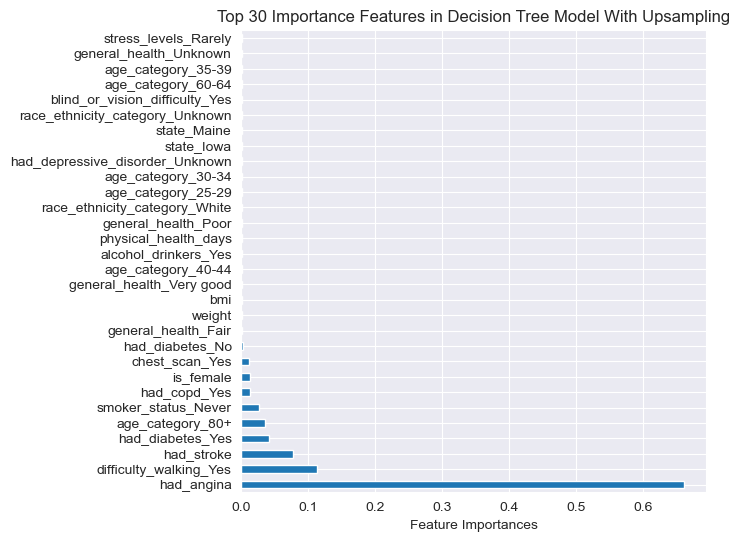

In [251]:
# Visualize the top 40 important features
plt.figure(figsize=(15, 15))
dt_feature_importance_df.head(30).plot(kind='barh', legend=False)
plt.title('Top 30 Importance Features in Decision Tree Model With Upsampling')
plt.xlabel('Feature Importances')

plt.show()

In [250]:
# Create a list of 11 important features in Decision Tree
dt_important_features = dt_feature_importance_df.head(11).index.tolist()

dt_important_features

['had_angina',
 'difficulty_walking_Yes',
 'had_stroke',
 'had_diabetes_Yes',
 'age_category_80+',
 'smoker_status_Never',
 'had_copd_Yes',
 'is_female',
 'chest_scan_Yes',
 'had_diabetes_No',
 'general_health_Fair']

**Takeaways**:
- In the Decision Tree model, only 11 out of 149 features (ranging from `chest_scan_yes` to `had_angina`) were found to significantly contribute to predicting the risk of experiencing a heart attack. This indicates that a vast number of features were deemed unimportant, potentially leading to overfitting. 
- The presence of many irrelevant features likely contributes to the gap between the recall on the training and test datasets. Reducing or refining the feature set could help mitigate this issue and improve model generalization.
---

### 7.3 Decision Tree With Downsampling (scaled, without PCA) <a class="anchor" id="7c"></a>

c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Confusion Matrix: 


<Figure size 300x300 with 0 Axes>

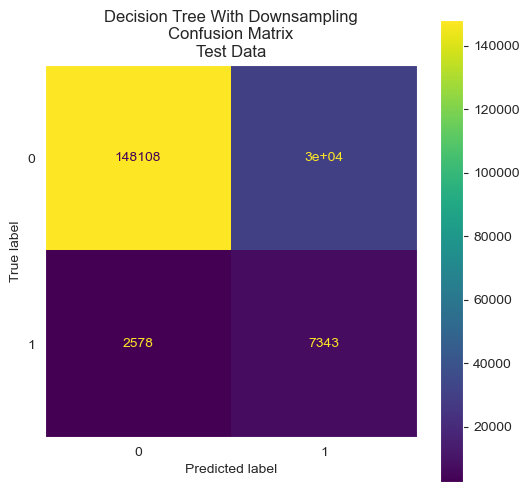

Test Data Classification Report: 
==================================================================               precision    recall  f1-score   support

           0       0.98      0.83      0.90    178076
           1       0.20      0.74      0.31      9921

    accuracy                           0.83    187997
   macro avg       0.59      0.79      0.61    187997
weighted avg       0.94      0.83      0.87    187997

Recall Score:
Train: 0.767
Test: 0.740 
False Positive Rate:
Train: 0.161
Test: 0.168 
Accuracy Score:
Train: 0.803
Test: 0.827 
Precision Score:
Train: 0.826
Test: 0.197 
F1 Score:
Train: 0.795
Test: 0.311 
AUC Score:
Train: 0.888
Test: 0.854 


In [236]:
###############
# MODEL FITTING #
###############

# Downsampled Data
dt_downsampled = DecisionTreeClassifier(max_depth=7, random_state=42)
dt_downsampled.fit(X_train_scaled_downsampled, y_train_downsampled)

# Hard Predictions for train and test data
y_pred_train = dt_downsampled.predict(X_train_scaled_downsampled)
y_pred_test = dt_downsampled.predict(X_test_scaled)

# Predicted probabilities for train and test data
y_pred_proba_train = dt_downsampled.predict_proba(X_train_scaled_downsampled)[:, 1]
y_pred_proba_test = dt_downsampled.predict_proba(X_test_scaled)[:, 1]

##################
# MODEL EVALUATION #
##################

print_line = "\n" + "===========" * 6

# Display Confusion Matrix
print('Confusion Matrix:', print_line)
plt.figure(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(dt_downsampled, X_test_scaled, y_test)
plt.title('Decision Tree With Downsampling\nConfusion Matrix\nTest Data')
plt.grid(False) 
plt.show()

# Print Classification Report
report_original = classification_report(y_test, y_pred_test)
print('Test Data Classification Report:', print_line, report_original)

# Print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train_downsampled, y_pred_train_downsampled):.3f}')
print(f'Test: {recall_score(y_test, y_pred_test):.3f}', print_line)

# Print False Positive Rate
print('False Positive Rate:')
print(f'Train: {false_positive_rate(y_train_downsampled, y_pred_train_downsampled):.3f}')
print(f'Test: {false_positive_rate(y_test, y_pred_test):.3f}', print_line)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train_downsampled, y_pred_train_downsampled):.3f}')
print(f'Test: {accuracy_score(y_test, y_pred_test):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train_downsampled, y_pred_train_downsampled):.3f}')
print(f'Test: {precision_score(y_test, y_pred_test):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train_downsampled, y_pred_train_downsampled):.3f}')
print(f'Test: {f1_score(y_test, y_pred_test):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train_downsampled, y_pred_proba_train_downsampled):.3f}')
print(f'Test: {roc_auc_score(y_test, y_pred_proba_test):.3f}', print_line)

---

### 7.4 Best Model with PCA - Decision Tree With Upsampling and PCA <a class="anchor" id="7d"></a>

Confusion matrices: 


<Figure size 300x300 with 0 Axes>

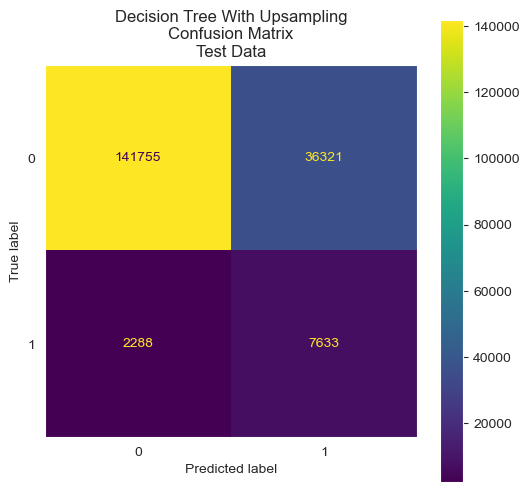

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.80      0.88    178076
           1       0.17      0.77      0.28      9921

    accuracy                           0.79    187997
   macro avg       0.58      0.78      0.58    187997
weighted avg       0.94      0.79      0.85    187997

Recall Score:
Train: 0.785
Test: 0.769 
False Positive Rate:
Train: 0.203
Test: 0.204 
Accuracy Score:
Train: 0.791
Test: 0.795 
Precision Score:
Train: 0.794
Test: 0.174 
F1 Score:
Train: 0.790
Test: 0.283 
AUC Score:
Train: 0.873
Test: 0.862 


In [ ]:
###############
# MODEL FITTING #
###############

# Upsampled Data
dt_upsampled_pca = DecisionTreeClassifier(max_depth=7, random_state=42)
dt_upsampled_pca.fit(X_train_pca_upsampled, y_train_upsampled)

# Hard Predictions for train and test data
y_pred_train_upsampled_pca = dt_upsampled_pca.predict(X_train_pca_upsampled)
y_pred_test_pca = dt_upsampled_pca.predict(X_test_pca_upsampled)

# Predicted probabilities for train and test data
y_pred_proba_train_upsampled_pca = dt_upsampled_pca.predict_proba(X_train_pca_upsampled)[:, 1]
y_pred_proba_test_pca = dt_upsampled_pca.predict_proba(X_test_pca_upsampled)[:, 1]

##################
# MODEL EVALUATION #
##################

print_line = "\n" + "===========" * 6

# Confusion Matrix
print('Confusion matrices:', print_line)

# Display confusion matrices
plt.figure(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(dt_upsampled_pca, X_test_pca_upsampled, y_test)
plt.title('Decision Tree With Upsampling And PCA\nConfusion Matrix\nTest Data')
plt.grid(False) 
plt.show()

# Print Classification Reports
report_original = classification_report(y_test, y_pred_test_pca)
print('Test Data classification report: ', print_line, report_original)

# Print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train_upsampled, y_pred_train_upsampled_pca):.3f}')
print(f'Test: {recall_score(y_test, y_pred_test_pca):.3f}', print_line)

# Print FPR
print('False Positive Rate:')
print(f'Train: {false_positive_rate(y_train_upsampled, y_pred_train_upsampled_pca):.3f}')
print(f'Test: {false_positive_rate(y_test, y_pred_test_pca):.3f}', print_line)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train_upsampled, y_pred_train_upsampled_pca):.3f}')
print(f'Test: {accuracy_score(y_test, y_pred_test_pca):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train_upsampled, y_pred_train_upsampled_pca):.3f}')
print(f'Test: {precision_score(y_test, y_pred_test_pca):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train_upsampled, y_pred_train_upsampled_pca):.3f}')
print(f'Test: {f1_score(y_test, y_pred_test_pca):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train_upsampled, y_pred_proba_train_upsampled_pca):.3f}')
print(f'Test: {roc_auc_score(y_test, y_pred_proba_test_pca):.3f}', print_line)

In [260]:
# Since this is the best performer, store the metrics in the DataFrame
recall_best_model.loc['Decision Tree', :] = [
    recall_score(y_train_upsampled, y_pred_train_upsampled_pca).round(3), 
    recall_score(y_test, y_pred_test_pca).round(3)
    ]

fpr_best_model.loc['Decision Tree', :] = [
    false_positive_rate(y_train_upsampled, y_pred_train_upsampled_pca).round(3), 
    false_positive_rate(y_test, y_pred_test_pca).round(3)
    ]

---

### 7.5 Decision Tree Baseline Modeling Summary <a class="anchor" id="7e"></a>

**Metrics using test data:**<br>
All Models uses hyperparameters: max_depth=7 
| Model                   | PCA | Recall | FPR  | Accuracy | Precision | F1 Score | AUC   | Notes                               |
|-------------------------|-----|--------|------|----------|-----------|----------|-------|-------------------------------------|
| Decision Tree           | No  | 0.240  | 0.010| 0.950    | 0.565     | 0.337    | 0.855 | Imbalanced                          |
| Decision Tree           | No  | 0.744  | 0.170| 0.825    | 0.196     | 0.310    | 0.856 | Upsampled,              |
| Decision Tree       | No| 0.740 | 0.168| 0.817| 0.189| 0.302| 0.854 | Downsampled      |
| **Decision Tree**           | **Yes** | **0.769**  | **0.204**| 0.795    | 0.174     | 0.283    | 0.862 | **Upsampled with PCA**  |


- So far, hyperparameter tuning has not been conducted on any of the Decision models. Due to the tendency of Decision Trees to overfit the data, I have set the maximum depth to 7 across all baseline models. 
- The Decision Tree model with upsampling and PCA achieves the highest recall score, although its false positive rate is slightly higher than that of the upsampled models without PCA. Given that a false positive rate of 20.4% is considered acceptable, I will select this model as the best performer.
- In the model interpretation of Decision Tree Model With Upsampling model, only 11 out of 149 features were found to significantly contribute to predicting the target. A vast number of unimportant features could potentially lead to overfitting, so reducing the feature could help improve generalization.
- All models trained on balanced datasets (upsampling, downsampling, oversampling) exhibit a significant gap in the precision score between training and test data. This discrepancy may be attributed to overfitting, especially given that the baseline models consist of 149 features. Additionally, the imbalance distribution in the test set plays a critical role. Recall the formula for $\text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}}$. In the test set, where negatives comprise 94.7% of the data, even a small false positive rate can result in a substantial number of false positives. This increase in false positives ultimately reduces the precision score, causing the discrepancy in train and test precision.

---




## 8 Baseline Modeling - Random Forest  <a class="anchor" id="8"></a>

### 8.1 Random Forest Imbalanced (with class imbalance and scaling, without PCA) <a class="anchor" id="8a"></a>

Confusion Matrix: 


<Figure size 300x300 with 0 Axes>

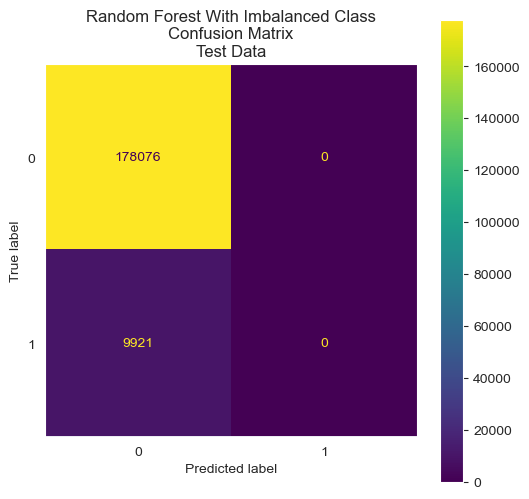

c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Test Data Classification Report: 
==================================================================               precision    recall  f1-score   support

           0       0.95      1.00      0.97    178076
           1       0.00      0.00      0.00      9921

    accuracy                           0.95    187997
   macro avg       0.47      0.50      0.49    187997
weighted avg       0.90      0.95      0.92    187997

Recall Score:
Train: 0.000
Test: 0.000 
False Positive Rate:
Train: 0.000
Test: 0.000 
Accuracy Score:
Train: 0.947
Test: 0.947 
Precision Score:
Train: 1.000
Test: 0.000 
F1 Score:
Train: 0.000
Test: 0.000 
AUC Score:


c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train: 0.878
Test: 0.873 


In [254]:
###############
# MODEL FITTING #
###############

# Fit Random Forest Classifier on Imbalanced Data
rf_imbalanced = RandomForestClassifier(n_estimators=50, max_depth=7, random_state=42)
rf_imbalanced.fit(X_train_scaled, y_train)  

# Hard Predictions for train and test data
y_pred_train = rf_imbalanced.predict(X_train_scaled)
y_pred_test = rf_imbalanced.predict(X_test_scaled)

# Predicted probabilities for train and test data
y_pred_proba_train = rf_imbalanced.predict_proba(X_train_scaled)[:, 1]
y_pred_proba_test = rf_imbalanced.predict_proba(X_test_scaled)[:, 1]

##################
# MODEL EVALUATION #
##################

print_line = "\n" + "===========" * 6

# Display Confusion Matrix
print('Confusion Matrix:', print_line)
plt.figure(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(rf_imbalanced, X_test_scaled, y_test)
plt.title('Random Forest With Imbalanced Class\nConfusion Matrix\nTest Data')
plt.grid(False) 
plt.show()

# Print Classification Report
report_original = classification_report(y_test, y_pred_test)
print('Test Data Classification Report:', print_line, report_original)

# Print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train, y_pred_train):.3f}')
print(f'Test: {recall_score(y_test, y_pred_test):.3f}', print_line)

# Print FPR
print('False Positive Rate:')
print(f'Train: {false_positive_rate(y_train, y_pred_train):.3f}')
print(f'Test: {false_positive_rate(y_test, y_pred_test):.3f}', print_line)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train, y_pred_train):.3f}')
print(f'Test: {accuracy_score(y_test, y_pred_test):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train, y_pred_train):.3f}')
print(f'Test: {precision_score(y_test, y_pred_test):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train, y_pred_train):.3f}')
print(f'Test: {f1_score(y_test, y_pred_test):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train, y_pred_proba_train):.3f}')
print(f'Test: {roc_auc_score(y_test, y_pred_proba_test):.3f}', print_line)

---

### 8.2 Random Forest With Upsampling (scaled, without PCA) <a class="anchor" id="8b"></a>

c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Confusion matrices: 


c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


<Figure size 300x300 with 0 Axes>

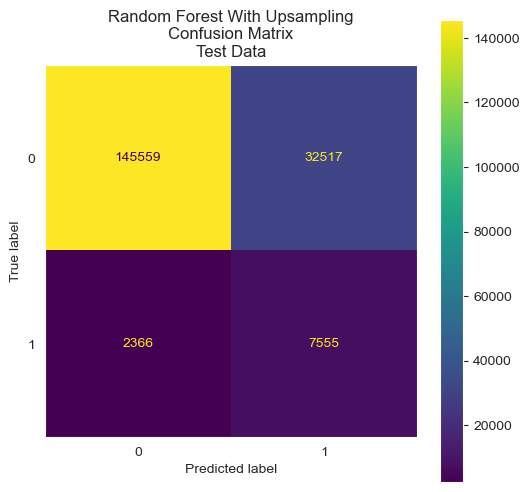

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.82      0.89    178076
           1       0.19      0.76      0.30      9921

    accuracy                           0.81    187997
   macro avg       0.59      0.79      0.60    187997
weighted avg       0.94      0.81      0.86    187997

Recall Score:
Train: 0.767
Test: 0.762 
False Positive Rate:
Train: 0.163
Test: 0.183 
Accuracy Score:
Train: 0.802
Test: 0.814 
Precision Score:
Train: 0.825
Test: 0.189 
F1 Score:
Train: 0.795
Test: 0.302 
AUC Score:
Train: 0.888
Test: 0.871 


In [258]:
###############
#MODEL FITTING#
###############

# Upsampled Data
rf_upsampled = RandomForestClassifier(n_estimators=50, max_depth=7, random_state=42)
rf_upsampled.fit(X_train_scaled_upsampled, y_train_upsampled)  

# Hard Predictions for train and test data
y_pred_train = rf_upsampled.predict(X_train_scaled_upsampled)
y_pred_test = rf_upsampled.predict(X_test_scaled)

# Predicted probabilities for train and test data
y_pred_proba_train = rf_upsampled.predict_proba(X_train_scaled_upsampled)[:, 1]
y_pred_proba_test = rf_upsampled.predict_proba(X_test_scaled)[:, 1]

##################
#Model Evaluation#
##################

print_line = "\n" + "===========" * 6

# Confusion Matrix
print('Confusion matrices:', print_line)

# Display confusion matrices
plt.figure(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(rf_upsampled, X_test_scaled, y_test)
plt.title('Random Forest With Upsampling\nConfusion Matrix\nTest Data')
plt.grid(False) 
plt.show()

# Print Classification Reports
report_original = classification_report(y_test, y_pred_test)
print('Test Data classification report: ', print_line, report_original)

# Print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train_upsampled, y_pred_train_upsampled):.3f}')
print(f'Test: {recall_score(y_test, y_pred_test):.3f}', print_line)

# Print FPR
print('False Positive Rate:')
print(f'Train: {false_positive_rate(y_train_upsampled, y_pred_train_upsampled):.3f}')
print(f'Test: {false_positive_rate(y_test, y_pred_test):.3f}', print_line)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train_upsampled, y_pred_train_upsampled):.3f}')
print(f'Test: {accuracy_score(y_test, y_pred_test):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train_upsampled, y_pred_train_upsampled):.3f}')
print(f'Test: {precision_score(y_test, y_pred_test):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train_upsampled, y_pred_train_upsampled):.3f}')
print(f'Test: {f1_score(y_test, y_pred_test):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train_upsampled, y_pred_proba_train_upsampled):.3f}')
print(f'Test: {roc_auc_score(y_test, y_pred_proba_test):.3f}', print_line)

---

### 8.3 Random Forest With Downsampling (scaled, without PCA) <a class="anchor" id="8c"></a>

c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Confusion matrices: 


c:\Users\yehua\anaconda3\envs\heart_attack_prediction_env\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


<Figure size 300x300 with 0 Axes>

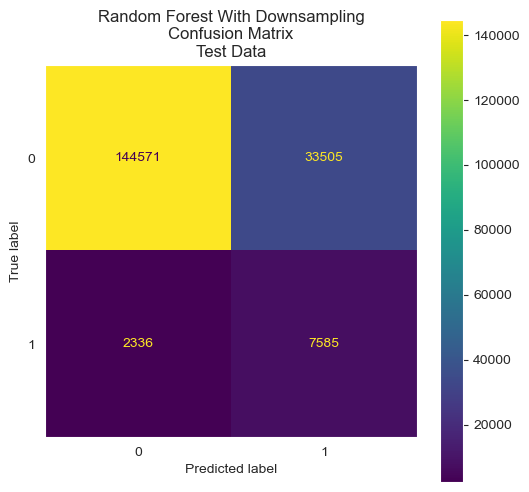

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.81      0.89    178076
           1       0.18      0.76      0.30      9921

    accuracy                           0.81    187997
   macro avg       0.58      0.79      0.59    187997
weighted avg       0.94      0.81      0.86    187997

Recall Score:
Train: 0.767
Test: 0.765 
False Positive Rate:
Train: 0.161
Test: 0.188 
Accuracy Score:
Train: 0.803
Test: 0.809 
Precision Score:
Train: 0.826
Test: 0.185 
F1 Score:
Train: 0.795
Test: 0.297 
AUC Score:
Train: 0.888
Test: 0.869 


In [269]:
###############
#MODEL FITTING#
###############

# Downsampled Data
rf_downsampled = RandomForestClassifier(n_estimators=50, max_depth=7, random_state=42)
rf_downsampled.fit(X_train_scaled_downsampled, y_train_downsampled)  

# Hard Predictions for train and test data
y_pred_train = rf_downsampled.predict(X_train_scaled_downsampled)
y_pred_test = rf_downsampled.predict(X_test_scaled)

# Predicted probabilities for train and test data
y_pred_proba_train = rf_downsampled.predict_proba(X_train_scaled_downsampled)[:, 1]
y_pred_proba_test = rf_downsampled.predict_proba(X_test_scaled)[:, 1]

##################
#Model Evaluation#
##################

print_line = "\n" + "===========" * 6

# Confusion Matrix
print('Confusion matrices:', print_line)

# Display confusion matrices
plt.figure(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(rf_downsampled, X_test_scaled, y_test)
plt.title('Random Forest With Downsampling\nConfusion Matrix\nTest Data')
plt.grid(False) 
plt.show()

# Print Classification Reports
report_original = classification_report(y_test, y_pred_test)
print('Test Data classification report: ', print_line, report_original)

# Print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train_downsampled, y_pred_train_downsampled):.3f}')
print(f'Test: {recall_score(y_test, y_pred_test):.3f}', print_line)

# Print False Positive Rate
print('False Positive Rate:')
print(f'Train: {false_positive_rate(y_train_downsampled, y_pred_train_downsampled):.3f}')
print(f'Test: {false_positive_rate(y_test, y_pred_test):.3f}', print_line)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train_downsampled, y_pred_train_downsampled):.3f}')
print(f'Test: {accuracy_score(y_test, y_pred_test):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train_downsampled, y_pred_train_downsampled):.3f}')
print(f'Test: {precision_score(y_test, y_pred_test):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train_downsampled, y_pred_train_downsampled):.3f}')
print(f'Test: {f1_score(y_test, y_pred_test):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train_downsampled, y_pred_proba_train_downsampled):.3f}')
print(f'Test: {roc_auc_score(y_test, y_pred_proba_test):.3f}', print_line)

In [270]:
# Since this is the best performer, store the metrics in the DataFrame
recall_best_model.loc['Random Forest', :] = [
    recall_score(y_train_downsampled, y_pred_train_downsampled).round(3), 
    recall_score(y_test, y_pred_test).round(3)
    ]

fpr_best_model.loc['Random Forest', :] = [
    false_positive_rate(y_train_downsampled, y_pred_train_downsampled).round(3), 
    false_positive_rate(y_test, y_pred_test).round(3)
    ]

---



#### Model Interpretation

The Random Forest model includes a feature importance metric that measures how much each feature contributes to the model's predictions. Features with higher importance scores are considered more impactful within the model. In this section, I will:
1. Find the top 30 features with the highest importance scores.
2. Visualize the most influential features.

In [274]:
# Retrieve the feature importances from Random Forest with downsampling model
rf_importances = rf_downsampled.feature_importances_

# Create a DataFrame of each feature and its importance in Random Forest Model
rf_feature_importance_df = pd.DataFrame(rf_importances.reshape(-1, 1), 
                                     index= X_train.columns,
                                     columns=['feature_importance'])

# Sort the feature importance DataFramce and show top five rows
rf_feature_importance_df = rf_feature_importance_df.sort_values(by='feature_importance', ascending=False)

rf_feature_importance_df.head()

,feature_importance
had_angina,0.308382
had_stroke,0.070300
difficulty_walking_Yes,0.068732
pneumo_vax_Yes,0.065475
had_diabetes_Yes,0.051947


<Figure size 1500x1500 with 0 Axes>

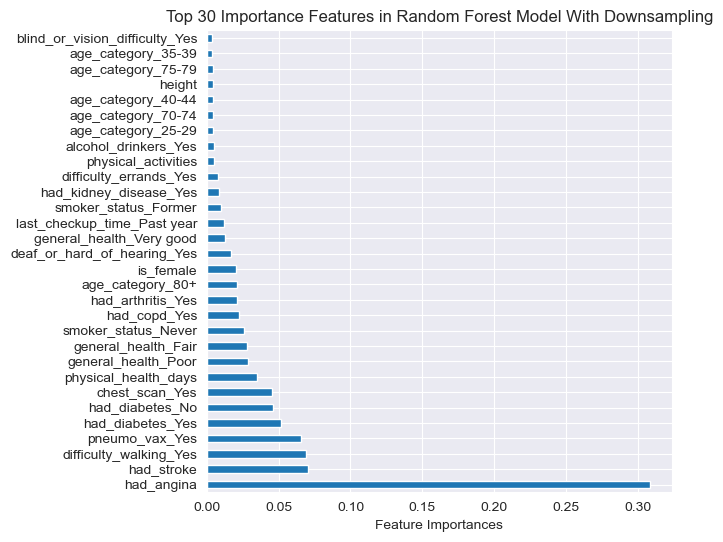

In [275]:
# Visualize the top 40 important features
plt.figure(figsize=(15, 15))
rf_feature_importance_df.head(30).plot(kind='barh', legend=False)
plt.title('Top 30 Importance Features in Random Forest Model With Downsampling')
plt.xlabel('Feature Importances')

plt.show()

In [276]:
# Create a list of important features from Random Forest
rf_important_features = rf_feature_importance_df.head(30).index.tolist()

rf_important_features


['had_angina',
 'had_stroke',
 'difficulty_walking_Yes',
 'pneumo_vax_Yes',
 'had_diabetes_Yes',
 'had_diabetes_No',
 'chest_scan_Yes',
 'physical_health_days',
 'general_health_Poor',
 'general_health_Fair',
 'smoker_status_Never',
 'had_copd_Yes',
 'had_arthritis_Yes',
 'age_category_80+',
 'is_female',
 'deaf_or_hard_of_hearing_Yes',
 'general_health_Very good',
 'last_checkup_time_Past year',
 'smoker_status_Former',
 'had_kidney_disease_Yes',
 'difficulty_errands_Yes',
 'physical_activities',
 'alcohol_drinkers_Yes',
 'age_category_25-29',
 'age_category_70-74',
 'age_category_40-44',
 'height',
 'age_category_75-79',
 'age_category_35-39',
 'blind_or_vision_difficulty_Yes']

**Takeaways**:
- Compared to the Decision Tree model, a greater number of features contributed to the prediction of the target variable in the Random Forest model. However, the proportion of important features remains relatively low, as there are clearly fewer than 30 important features out of a total of 149.
- By comparing the important features in the Decision Tree and Logistic Regression models, I found that many of the top-ranked important features in the Random Forest model, such as `had_angina`, `difficult_walking_Yes`, `had_stroke`, and `age_category_80+`,etc., are also considered important across the other models. This suggests a consistent identification of key predictors among the different modeling approaches.
---


### 8.4 Random Forest Baseline Modeling Summary  <a class="anchor" id="8d"></a>

**Metrics using test data:**<br>
All Models uses hyperparameters: n_estimators=50, max_depth=7 
| Model                   | PCA | Recall | FPR  | Accuracy | Precision | F1 Score | AUC   | Notes                       |
|-------------------------|-----|--------|------|----------|-----------|----------|-------|-----------------------------|
| Random Forest           | No  | 0.000  | 1.000| 0.947    | 0.000     | 0.000    | 0.873 | Imbalanced                  |
| Random Forest       | No  | 0.762  | 0.183| 0.814    | 0.189     | 0.302    | 0.871 | Upsampled |
| **Random Forest**           | No  | **0.765**  | **0.188**| 0.809    | 0.185     | 0.297   | 0.869 | **Downsampled**   |


- So far, hyperparameter tuning has not been conducted on any of the Random Forest models. Due to the tendency of Decision Trees to overfit the data, I have set the maximum depth to 7 across all baseline models. The models utilizing both upsampling and downsampling exhibit very similar performance, with the downampling model achieving slightly better Recall metrics.
- The first Random Forest Model, affected by class imbalance, predicts all negatives, resulting in zero true positives, and consequently, both recall and false positive rate are zero. Despite this, the model achieves a relatively high AUC score, reflecting its confidence to distinguish between classes. This suggests that while predictions remain below the default threshold at 0.5, the model assigns higher probabilities to positive instances compared to negative ones.
- Comparing the important features in the Decision Tree and Logistic Regression models, I found that many top-ranked features in the Random Forest model, such as `had_angina`, `difficult_walking_Yes`, `had_stroke`, and `age_category_80+`, etc., are also recognized as important in the other models. This indicates a consistent identification of key predictors across different approaches.

---




## 9 Baseline Modeling - XGBoost  <a class="anchor" id="9"></a>

### 9.1 XGBoost Imbalanced (with class imbalance and scaling, without PCA) <a class="anchor" id="9a"></a>

Confusion Matrix: 


<Figure size 300x300 with 0 Axes>

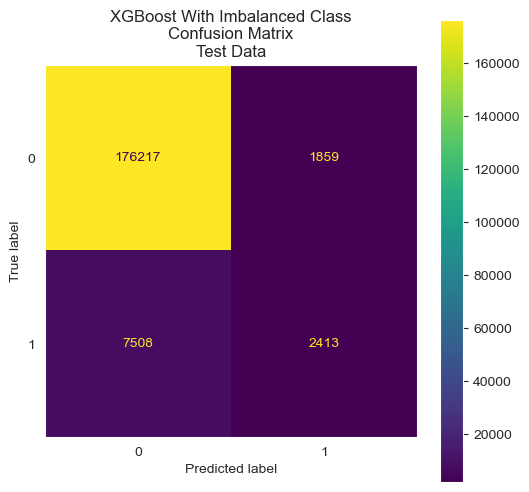

Test Data Classification Report: 
==================================================================               precision    recall  f1-score   support

           0       0.96      0.99      0.97    178076
           1       0.56      0.24      0.34      9921

    accuracy                           0.95    187997
   macro avg       0.76      0.62      0.66    187997
weighted avg       0.94      0.95      0.94    187997

Recall Score:
Train: 0.293
Test: 0.243 
False Positive Rate:
Train: 0.007
Test: 0.010 
Accuracy Score:
Train: 0.956
Test: 0.950 
Precision Score:
Train: 0.687
Test: 0.565 
F1 Score:
Train: 0.411
Test: 0.340 
AUC Score:
Train: 0.908
Test: 0.882 


In [277]:
###############
# MODEL FITTING #
###############

# Fit XGBoost Classifier on Imbalanced Data
xgb_imalanced = XGBClassifier(random_state=42)
xgb_imalanced.fit(X_train_scaled, y_train)  # Using the original scaled data

# Hard Predictions for train and test data
y_pred_train = xgb_imalanced.predict(X_train_scaled)
y_pred_test = xgb_imalanced.predict(X_test_scaled)

# Predicted probabilities for train and test data
y_pred_proba_train = xgb_imalanced.predict_proba(X_train_scaled)[:, 1]
y_pred_proba_test = xgb_imalanced.predict_proba(X_test_scaled)[:, 1]

##################
# MODEL EVALUATION #
##################

print_line = "\n" + "===========" * 6

# Display Confusion Matrix
print('Confusion Matrix:', print_line)
plt.figure(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(xgb_imalanced, X_test_scaled, y_test)
plt.title('XGBoost With Imbalanced Class\nConfusion Matrix\nTest Data')
plt.grid(False) 
plt.show()

# Print Classification Report
report_original = classification_report(y_test, y_pred_test)
print('Test Data Classification Report:', print_line, report_original)

# Print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train, y_pred_train):.3f}')
print(f'Test: {recall_score(y_test, y_pred_test):.3f}', print_line)

# Print FPR
print('False Positive Rate:')
print(f'Train: {false_positive_rate(y_train, y_pred_train):.3f}')
print(f'Test: {false_positive_rate(y_test, y_pred_test):.3f}', print_line)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train, y_pred_train):.3f}')
print(f'Test: {accuracy_score(y_test, y_pred_test):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train, y_pred_train):.3f}')
print(f'Test: {precision_score(y_test, y_pred_test):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train, y_pred_train):.3f}')
print(f'Test: {f1_score(y_test, y_pred_test):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train, y_pred_proba_train):.3f}')
print(f'Test: {roc_auc_score(y_test, y_pred_proba_test):.3f}', print_line)

---

### 9.2 XGBoost With Upsampling (scaled, without PCA) <a class="anchor" id="9b"></a>

Confusion matrices: 


<Figure size 300x300 with 0 Axes>

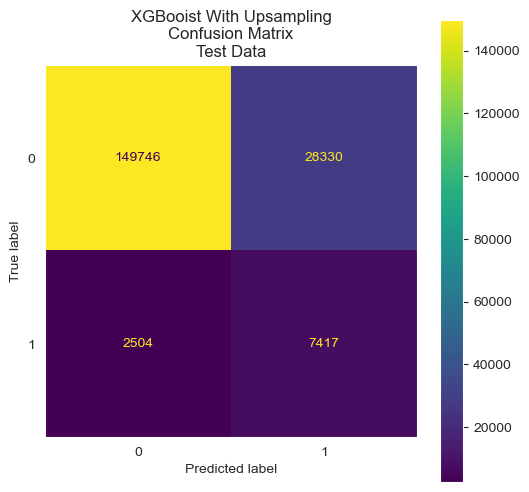

Test Data classification report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.84      0.91    178076
           1       0.21      0.75      0.32      9921

    accuracy                           0.84    187997
   macro avg       0.60      0.79      0.62    187997
weighted avg       0.94      0.84      0.88    187997

Recall Score:
Train: 0.767
Test: 0.748 
False Positive Rate:
Train: 0.163
Test: 0.159 
Accuracy Score:
Train: 0.802
Test: 0.836 
Precision Score:
Train: 0.825
Test: 0.207 
F1 Score:
Train: 0.795
Test: 0.325 
AUC Score:
Train: 0.888
Test: 0.880 


In [247]:
###############
#MODEL FITTING#
###############

# Upsampled Data
xgb_upsampled = XGBClassifier(random_state=42)
xgb_upsampled.fit(X_train_scaled_upsampled, y_train_upsampled)

# Hard Predictions for train and test data
y_pred_train = xgb_upsampled.predict(X_train_scaled_upsampled)
y_pred_test = xgb_upsampled.predict(X_test_scaled)

# Predicted probabilities for train and test data
y_pred_proba_train = xgb_upsampled.predict_proba(X_train_scaled_upsampled)[:, 1]
y_pred_proba_test = xgb_upsampled.predict_proba(X_test_scaled)[:, 1]

##################
#Model Evaluation#
##################

print_line = "\n" + "===========" * 6

# Confusion Matrix
print('Confusion matrices:', print_line)

# Display confusion matrices
plt.figure(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(xgb_upsampled, X_test_scaled, y_test)
plt.title('XGBooist With Upsampling\nConfusion Matrix\nTest Data')
plt.grid(False) 
plt.show()

# Print Classification Reports
report_original = classification_report(y_test, y_pred_test)
print('Test Data classification report: ', print_line, report_original)

# Print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train_upsampled, y_pred_train_upsampled):.3f}')
print(f'Test: {recall_score(y_test, y_pred_test):.3f}', print_line)

# Print FPR
print('False Positive Rate:')
print(f'Train: {false_positive_rate(y_train_upsampled, y_pred_train_upsampled):.3f}')
print(f'Test: {false_positive_rate(y_test, y_pred_test):.3f}', print_line)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train_upsampled, y_pred_train_upsampled):.3f}')
print(f'Test: {accuracy_score(y_test, y_pred_test):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train_upsampled, y_pred_train_upsampled):.3f}')
print(f'Test: {precision_score(y_test, y_pred_test):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train_upsampled, y_pred_train_upsampled):.3f}')
print(f'Test: {f1_score(y_test, y_pred_test):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train_upsampled, y_pred_proba_train_upsampled):.3f}')
print(f'Test: {roc_auc_score(y_test, y_pred_proba_test):.3f}', print_line)

---

### 9.3 XGBoost With Downsampling (scaled, without PCA) <a class="anchor" id="9c"></a>

Confusion Matrix: 


<Figure size 300x300 with 0 Axes>

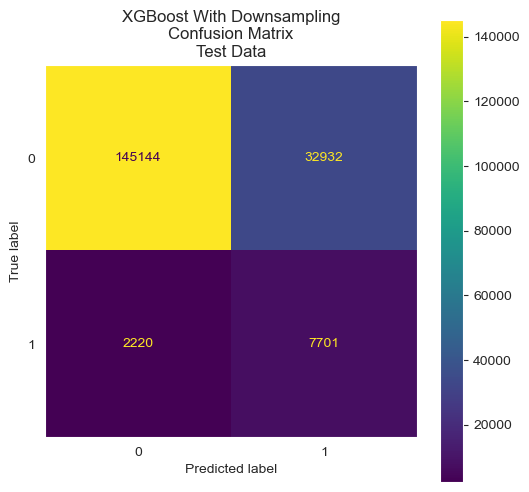

Test Data Classification Report: 
==================================================================               precision    recall  f1-score   support

           0       0.98      0.82      0.89    178076
           1       0.19      0.78      0.30      9921

    accuracy                           0.81    187997
   macro avg       0.59      0.80      0.60    187997
weighted avg       0.94      0.81      0.86    187997

Recall Score:
Train: 0.767
Test: 0.776 
False Positive Rate:
Train: 0.161
Test: 0.185 
Accuracy Score:
Train: 0.803
Test: 0.813 
Precision Score:
Train: 0.826
Test: 0.190 
F1 Score:
Train: 0.795
Test: 0.305 
AUC Score:
Train: 0.888
Test: 0.880 


In [280]:
###############
# MODEL FITTING #
###############

# Downsampled Data
xgb_downsampled = XGBClassifier(random_state=42)
xgb_downsampled.fit(X_train_scaled_downsampled, y_train_downsampled)

# Hard Predictions for train and test data
y_pred_train = xgb_downsampled.predict(X_train_scaled_downsampled)
y_pred_test = xgb_downsampled.predict(X_test_scaled)

# Predicted probabilities for train and test data
y_pred_proba_train = xgb_downsampled.predict_proba(X_train_scaled_downsampled)[:, 1]
y_pred_proba_test = xgb_downsampled.predict_proba(X_test_scaled)[:, 1]

##################
# MODEL EVALUATION #
##################

print_line = "\n" + "===========" * 6

# Display Confusion Matrix
print('Confusion Matrix:', print_line)
plt.figure(figsize=(3, 3))
ConfusionMatrixDisplay.from_estimator(xgb_downsampled, X_test_scaled, y_test)
plt.title('XGBoost With Downsampling\nConfusion Matrix\nTest Data')
plt.grid(False) 
plt.show()

# Print Classification Report
report_original = classification_report(y_test, y_pred_test)
print('Test Data Classification Report:', print_line, report_original)

# Print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train_downsampled, y_pred_train_downsampled):.3f}')
print(f'Test: {recall_score(y_test, y_pred_test):.3f}', print_line)

# Print False Positive Rate
print('False Positive Rate:')
print(f'Train: {false_positive_rate(y_train_downsampled, y_pred_train_downsampled):.3f}')
print(f'Test: {false_positive_rate(y_test, y_pred_test):.3f}', print_line)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train_downsampled, y_pred_train_downsampled):.3f}')
print(f'Test: {accuracy_score(y_test, y_pred_test):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train_downsampled, y_pred_train_downsampled):.3f}')
print(f'Test: {precision_score(y_test, y_pred_test):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train_downsampled, y_pred_train_downsampled):.3f}')
print(f'Test: {f1_score(y_test, y_pred_test):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train_downsampled, y_pred_proba_train_downsampled):.3f}')
print(f'Test: {roc_auc_score(y_test, y_pred_proba_test):.3f}', print_line)

In [281]:
# Since this is the best performer, store the metrics in the DataFrame
recall_best_model.loc['XGBoost', :] = [
    recall_score(y_train_downsampled, y_pred_train_downsampled).round(3), 
    recall_score(y_test, y_pred_test).round(3)
    ]

fpr_best_model.loc['XGBoost', :] = [
    false_positive_rate(y_train_downsampled, y_pred_train_downsampled).round(3), 
    false_positive_rate(y_test, y_pred_test).round(3)
    ]

---

#### Model Interpretation

The XGBoost model includes a feature importance metric that measures how much each feature contributes to the model's predictions. Features with higher importance scores are considered more impactful within the model. In this section, I will:
1. Find the top 30 features with the highest importance scores.
2. Visualize the most influential features.

In [284]:
# Get feature importances
xgb_importances = xgb_downsampled.feature_importances_

# Create a DataFrame with features and Feature importances
xgb_feature_importance_df = pd.DataFrame(
    xgb_importances.reshape(-1, 1),
    index=X_train.columns,
    columns=['feature_importance']
)

# Sort by the feature importance and show the top five rows
xgb_feature_importance_df = xgb_feature_importance_df.sort_values(by='feature_importance', ascending=False)
xgb_feature_importance_df.head(5)

,feature_importance
had_angina,0.438271
difficulty_walking_Yes,0.045301
had_stroke,0.033620
had_diabetes_Yes,0.022288
age_category_80+,0.020082


<Figure size 1500x1500 with 0 Axes>

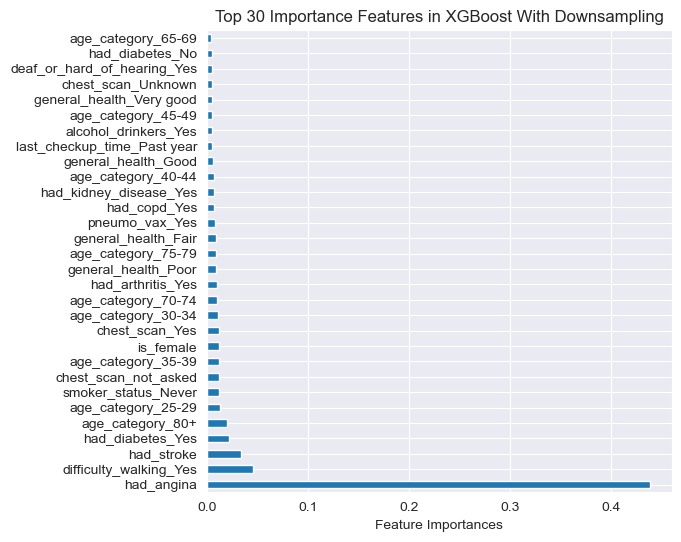

In [285]:
# Visualize the top 40 important features
plt.figure(figsize=(15, 15))
xgb_feature_importance_df.head(30).plot(kind='barh', legend=False)
plt.title('Top 30 Importance Features in XGBoost With Downsampling')
plt.xlabel('Feature Importances')

plt.show()

In [286]:
# Create a list of important features in XGBoost
xgb_important_features = xgb_feature_importance_df.head(30).index.tolist()

xgb_important_features

['had_angina',
 'difficulty_walking_Yes',
 'had_stroke',
 'had_diabetes_Yes',
 'age_category_80+',
 'age_category_25-29',
 'smoker_status_Never',
 'chest_scan_not_asked',
 'age_category_35-39',
 'is_female',
 'chest_scan_Yes',
 'age_category_30-34',
 'age_category_70-74',
 'had_arthritis_Yes',
 'general_health_Poor',
 'age_category_75-79',
 'general_health_Fair',
 'pneumo_vax_Yes',
 'had_copd_Yes',
 'had_kidney_disease_Yes',
 'age_category_40-44',
 'general_health_Good',
 'last_checkup_time_Past year',
 'alcohol_drinkers_Yes',
 'age_category_45-49',
 'general_health_Very good',
 'chest_scan_Unknown',
 'deaf_or_hard_of_hearing_Yes',
 'had_diabetes_No',
 'age_category_65-69']

**Takeaways**:
- Compared to the Random Forest model, fewer features contributed to the prediction of the target variable in the XGBoost model. Similarly, `had_angina` has the highest predicive power with the dominant importance value. The remaining features among the top 20 important features appear to have relatively little predictive power for the target variable.

---

### 9.4 Best Model with PCA - XGBoost With Downsampling and PCA <a class="anchor" id="9d"></a>

Confusion matrices: 


<Figure size 500x500 with 0 Axes>

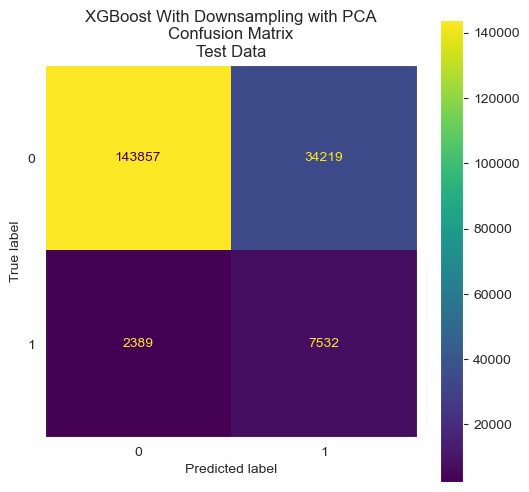

Test Data Classification Report:  
==================================================================               precision    recall  f1-score   support

           0       0.98      0.81      0.89    178076
           1       0.18      0.76      0.29      9921

    accuracy                           0.81    187997
   macro avg       0.58      0.78      0.59    187997
weighted avg       0.94      0.81      0.86    187997

Recall Score:
Train: 0.873
Test: 0.759 
False Positive Rate:
Train: 0.082
Test: 0.192 
Accuracy Score:
Train: 0.895
Test: 0.805 
Precision Score:
Train: 0.914
Test: 0.180 
F1 Score:
Train: 0.893
Test: 0.292 
AUC Score:
Train: 0.960
Test: 0.868 


In [289]:
###############
# MODEL FITTING #
###############

# Downsampled Data
xgb_downsampled_pca = XGBClassifier(random_state=42)
xgb_downsampled_pca.fit(X_train_pca_downsampled, y_train_downsampled)

# Hard Predictions for train and test data
y_pred_train_downsampled_pca = xgb_downsampled_pca.predict(X_train_pca_downsampled)
y_pred_test_pca = xgb_downsampled_pca.predict(X_test_pca_downsampled)

# Predicted probabilities for train and test data
y_pred_proba_train_downsampled_pca = xgb_downsampled_pca.predict_proba(X_train_pca_downsampled)[:, 1]
y_pred_proba_test_pca = xgb_downsampled_pca.predict_proba(X_test_pca_downsampled)[:, 1]

##################
# MODEL EVALUATION #
##################

print_line = "\n" + "===========" * 6

# Confusion Matrix
print('Confusion matrices:', print_line)

# Display confusion matrix for the test data
plt.figure(figsize=(5, 5))  # Adjusted size for better visibility
ConfusionMatrixDisplay.from_estimator(xgb_downsampled_pca, X_test_pca_downsampled, y_test)
plt.title('XGBoost With Downsampling with PCA\nConfusion Matrix\nTest Data')
plt.grid(False) 
plt.show()

# Print Classification Reports
report_original = classification_report(y_test, y_pred_test_pca)
print('Test Data Classification Report: ', print_line, report_original)

# Print Recall Score
print('Recall Score:')
print(f'Train: {recall_score(y_train_downsampled, y_pred_train_downsampled_pca):.3f}')
print(f'Test: {recall_score(y_test, y_pred_test_pca):.3f}', print_line)

# Print FPR
print('False Positive Rate:')
print(f'Train: {false_positive_rate(y_train_downsampled, y_pred_train_downsampled_pca):.3f}')
print(f'Test: {false_positive_rate(y_test, y_pred_test_pca):.3f}', print_line)

# Print Accuracy Score
print('Accuracy Score:')
print(f'Train: {accuracy_score(y_train_downsampled, y_pred_train_downsampled_pca):.3f}')
print(f'Test: {accuracy_score(y_test, y_pred_test_pca):.3f}', print_line)

# Print Precision Score
print('Precision Score:')
print(f'Train: {precision_score(y_train_downsampled, y_pred_train_downsampled_pca):.3f}')
print(f'Test: {precision_score(y_test, y_pred_test_pca):.3f}', print_line)

# Print F1 Score
print('F1 Score:')
print(f'Train: {f1_score(y_train_downsampled, y_pred_train_downsampled_pca):.3f}')
print(f'Test: {f1_score(y_test, y_pred_test_pca):.3f}', print_line)

# Print AUC Score
print('AUC Score:')
print(f'Train: {roc_auc_score(y_train_downsampled, y_pred_proba_train_downsampled_pca):.3f}')
print(f'Test: {roc_auc_score(y_test, y_pred_proba_test_pca):.3f}', print_line)

---

### 9.5 XGBoost Baseline Modeling Summary <a class="anchor" id="9e"></a>

**Metrics using test data:**<br>

| Model                   | PCA | Recall | FPR  | Accuracy | Precision | F1 Score | AUC   | Notes                       |
|-------------------------|-----|--------|------|----------|-----------|----------|-------|-----------------------------|
| XGBoost                 | No  | 0.243  | 0.010| 0.950    | 0.565     | 0.340    | 0.882 | Imbalanced                  |
| XGBoost                 | No  | 0.748  | 0.159| 0.836    | 0.207     | 0.325    | 0.880 | Upsampled     |
| **XGBoost**             | No  | **0.776**  | **0.185**| 0.813    | 0.190     | 0.305    | 0.880 | **Downsampled** |
| XGBoost             | Yes  | 0.759  | 0.192| 0.805    | 0.180     | 0.292    | 0.868 | Downsampled with PCA, overfitting|

- So far, hyperparameter tuning has not been conducted on any of the XGBoost models. Due to the tendency of Decision Trees to overfit the data, I have set the maximum depth to 7 across all baseline models. 
- The XGBoost with downsampling achieves the highest recall score, although its false positive rate is slightly higher than that of the upsampled models. Given that a false positive rate of 18.5% is considered acceptable, I will select this model as the best performer.
- XGBoost with PCA shows signs of overfitting, as evidenced by significantly lower accuracy and recall metrics on the test data compared to the training data.
- In the model interpretation of XGBoost Model With Downsampling model, about 20 out of 149 features were found to significantly contribute to predicting the target. A vast number of unimportant features could potentially lead to overfitting, so reducing the feature could help improve generalization.


---

## 10. Feature Analysis, Model Comparisons & Summary <a class="anchor" id="10"></a>

### 10.1 Important/Predictive Features in Various Baseline Models <a class="anchor" id="10a"></a>

- During the baseline modeling stage, I identified the important or predictive features in Logistic Regression, Decision Tree, Random Forest, and XGBoost.
- In this section, I will combine all these important features to determine the total number of unique important features and count how many times each feature has occurred across the four models.

([<matplotlib.axis.XTick at 0x275a6af5790>,
 [Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3'), Text(4, 0, '4')])

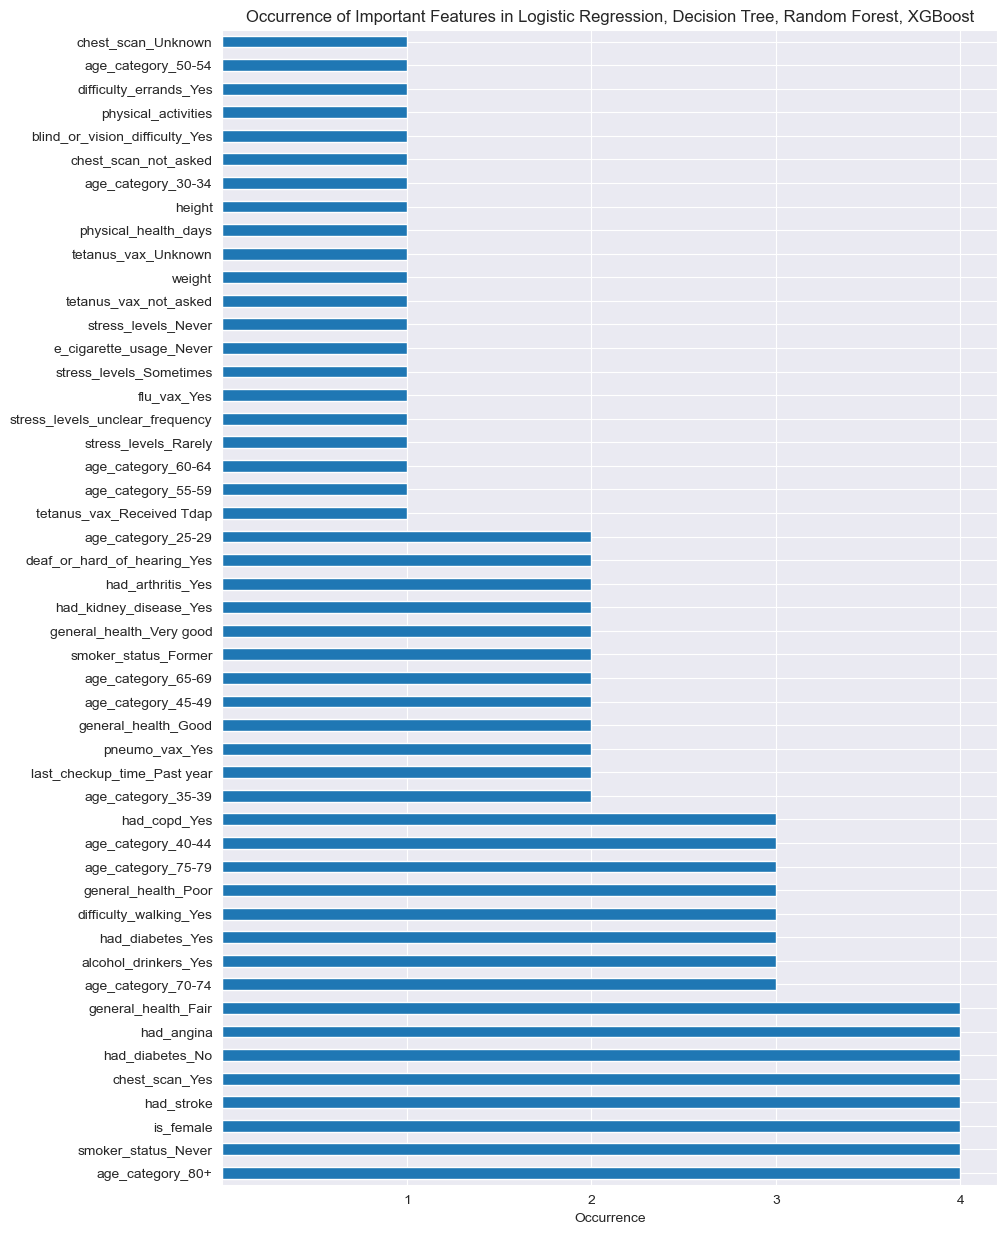

In [305]:
# Create a list of all important features
all_important_features = (
    logreg_important_features + 
    dt_important_features + 
    rf_important_features + 
    xgb_important_features
)

# Create a DataFrame of all important features
important_features_df = pd.DataFrame(all_important_features, columns=['Feature'])

# Count the appearance of important features in these four models
important_features_occurance = important_features_df['Feature'].value_counts()\
    .sort_values(ascending=False)

# Visualize 
plt.figure(figsize=(10, 15))
important_features_occurance.plot(kind='barh')
plt.title('Occurrence of Important Features in Logistic Regression, Decision Tree, Random Forest, XGBoost')
plt.xlabel('Occurrence')
plt.ylabel('')
plt.xticks(range(1, 5))

In [306]:
# Print the total number of features
print(f'Total number of features in baseline modeling: {X_train_encoded.shape[1]}')

# Print the number of all important features
print(f'Number of all important features: {len(important_features_occurance)}')

Total number of features in baseline modeling: 149
Number of all important features: 49


**Takeaways**:
- Despite aggregating all important features from four of the five classification models, fewer than one-third of the features are actually significant or predictive for the target variable, while the remaining two-thirds are considered unimportant. This significant number of excessive features poses a potential risk for overfitting in these models. Therefore, feature reduction and refinement should be conducted in the next stage to enhance model performance.

---

### 10.2 Model Comparison and Summary <a class="anchor" id="10b"></a>

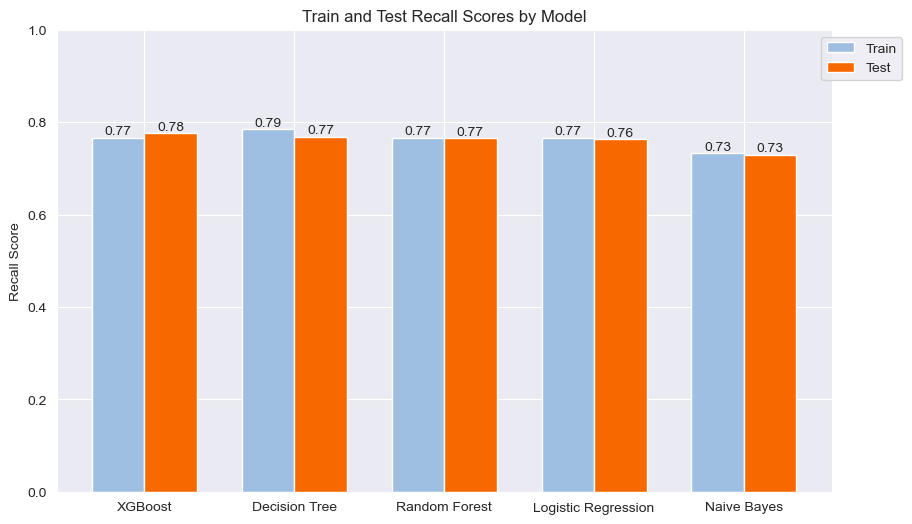

In [311]:
# Sort the DataFrame by test score
recall_best_model = recall_best_model.sort_values(by='Test', ascending=False)

# Plot the recall metrics of best performer within each classification model
plt.figure(figsize=(10, 6))

# Set up bar width and list of number of models 
bar_width = 0.35
x = range(len(recall_best_model))

# Plot train bars
train_bars = plt.bar(x, 
                     recall_best_model['Train'], 
                     width=bar_width, 
                     label='Train', 
                     color='#9EBFE2')

# Plot test bars next to train bars
test_bars = plt.bar([i + bar_width for i in x], 
                    recall_best_model['Test'], 
                    width=bar_width, label='Test', 
                    color='#F76900')

# Annotate bars with recall scores
for bar in train_bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}', 
             ha='center', va='bottom')

for bar in test_bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}', 
             ha='center', va='bottom')


plt.xticks([i + bar_width / 2 for i in x], recall_best_model.index)  # Set x-ticks to be centered
plt.title('Train and Test Recall Scores by Model')
plt.ylabel('Recall Score')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.ylim(0.0, 1.0)

plt.show()

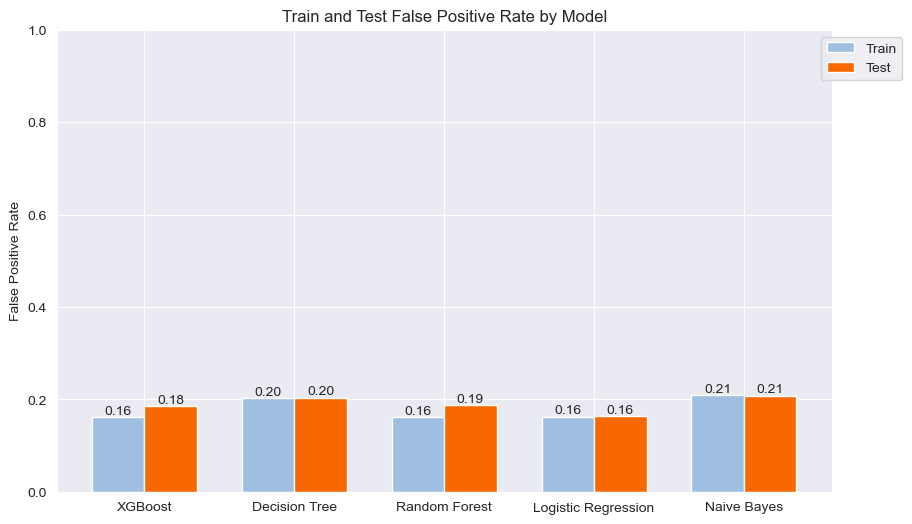

In [313]:
# Sort the DataFrame to align with the order in false positive score
fpr_best_model = fpr_best_model.loc[
    ['XGBoost', 'Decision Tree','Random Forest','Logistic Regression','Naive Bayes']
    ]

# Plot the fpr metrics of best performer within each classification model
plt.figure(figsize=(10, 6))

# Set up bar width and list of number of models 
bar_width = 0.35
x = range(len(fpr_best_model))

# Plot train bars
train_bars = plt.bar(x, 
                     fpr_best_model['Train'], 
                     width=bar_width, 
                     label='Train', 
                     color='#9EBFE2')

# Plot test bars next to train bars
test_bars = plt.bar([i + bar_width for i in x], 
                    fpr_best_model['Test'], 
                    width=bar_width, label='Test', 
                    color='#F76900')

# Annotate bars with false positive rate 
for bar in train_bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}', 
             ha='center', va='bottom')

for bar in test_bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}', 
             ha='center', va='bottom')


plt.xticks([i + bar_width / 2 for i in x], fpr_best_model.index)  # Set x-ticks to be centered
plt.title('Train and Test False Positive Rate by Model')
plt.ylabel('False Positive Rate')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.ylim(0.0, 1.0)

plt.show()

**Metrics Comparison Across Different Models (using test data):**<br>
random_state=42 is applied to all models that  incorporate randomness.

| Model                   | X_train     | Hyperparameters                      | PCA | Recall | FPR  | Accuracy | Precision | F1 Score | AUC   | Notes                       |
|-------------------------|-------------|--------------------------------------|-----|--------|------|----------|-----------|----------|-------|-----------------------------|
| Logistic Regression      | Upsampled   | max_iter=1000                       | No  |  0.763  |0.164 | 0.832    | 0.206     | 0.325    | 0.885  |                  |
| Naive Bayes             | Imbalanced |                                      | No  |  0.730  | 0.208 | 0.789    | 0.163     | 0.267    | 0.824 |                  |
| Decision Tree           | Upsampled | max_depth=7                         | Yes  | 0.769  | 0.204| 0.795    | 0.174     | 0.283    | 0.862 |                |
| Random Forest           | Downsampled   | n_estimators=50, max_depth=7       | No  | 0.765  | 0.188| 0.809    | 0.185     | 0.297   | 0.869 |                  |
| **XGBoost**             | **Downsampled** |                                  | **No** | **0.776**  | **0.185**| 0.813    | 0.190     | 0.305    | 0.880 |             |


**Summary:**
1. Up to this stage, I have evaluated several baseline models, including Logistic Regression, Naive Bayes, Decision Tree, Random Forest, and XGBoost. For each model, I trained on both imbalanced data and balanced data using upsampling and downsampling techniques. The table below presents the best performer for each model based on performance metrics. 
2. To reiterate the success metrics introduced in the beginning of this notebook, model performance will primarily be assessed using recall and the false positive rate (FPR). The objective is to prioritize achieving a high recall while maintaining the FPR at a reasonable level.
3. Among all baseline models, XGBoost with downsampling techniques is selected as the best performer. This model achieves the highest recall score of 0.776 while maintaining the second lowest false positive rate at 0.185.
4. No hyperparameter tuning was conducted during the baseline modeling phase; most hyperparameters were chosen based on intuition to help prevent overfitting and establish a fixed random seed.
5. All models employing upsampling and downsampling techniques to achieve balanced classes in the training data exhibit a significant gap in precision scores between the training and test datasets. This discrepancy may be attributed to overfitting, especially given that the baseline models consist of 149 features. Additionally, the imbalanced distribution in the test set plays a critical role. Recall the formula for precision:
 $\text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}}$.
In the test set, where negatives comprise 94.7% of the data, even a small false positive rate can lead to a substantial number of false positives. This increase in false positives ultimately reduces the precision score, contributing to the observed discrepancy between training and test precision.
6. I applied PCA to the best-performing models—Logistic Regression, Decision Tree, and XGBoost—to determine whether dimensionality reduction could mitigate overfitting or enhance model performance. However, only the Decision Tree model demonstrated improved performance on the test data.  During my analysis on reducing dimensionality with PCA, I discovered that it was not well-suited for the current combinantion of features, as it required over 110 principal components to achieve a total explained variance ratio of 90%.
7. As noted previously, over 67% of the features are considered unimportant, which contributes to the risk of overfitting. In the next phase, I will revisit feature engineering to identify and retain the most critical features while filtering out the less relevant ones. I will then assess if these changes can improve model performance. Following this, I will re-evaluate the models to determine if overfitting can be mitigated.

---



## 11 Export Data <a class="anchor" id="11"></a>

Export the data with initial feature engineering.

In [314]:
# Export df_engineer
df_engineer.to_csv("../data/processed/heart_attack_with_initial_feature_engineering.csv", index=False)

In [318]:
# Export important features
important_features_df.to_csv("../data/processed/important_features_baseline_models.csv", index=False)